In [201]:
import os

os.environ['OPENBLAS_NUM_THREADS'] = '20'
os.environ['MKL_NUM_THREADS'] = '20'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import datetime as dt
import copy
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import xarray as xr
import pickle
import random
import time
import signal
import multiprocessing
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from scipy import interpolate
import random
import lightgbm as lgb
import itertools
from scipy import spatial
import joblib



def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import sys
sys.path.insert(1,'/home/jsperezc/jupyter/AQ_Forecast/functions/')
import postprocessing
from preprocessing import *

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import RegressorChain, MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit



In [202]:
from trajectories import *

# Compute IFRP (just had to do it once)

In [203]:
# path_bt = '/var/data1/AQ_Forecast_DATA/historic/GFS/validation/Vientos/BT/'

In [204]:
# #################### LECTURA INCENDOS HISTÓRICOS ########################
# import datetime as dt
# df_fires = pd.read_csv('/var/data1/AQ_Forecast_DATA/historic/Fires/fire_archive_M-C61_246192.csv')

# str_time = df_fires['acq_time'].values.astype(str)
# str_time = np.array([str_time[i].zfill(4) for i in range(len(str_time))])
# str_date = df_fires['acq_date'].values.astype(str)

# dates_fires = np.array([dt.datetime.strptime(str_date[i]+' '+str_time[i],'%Y-%m-%d %H%M').replace(minute = 0) \
#     for i in range(len(str_time))])
# df_fires.index = dates_fires
# #df_fires.index = df_fires.index - dt.timedelta(hours = 5)
# print(df_fires.shape)

In [205]:
# def read_nc(file_i):
#     """Función que lee los archivos donde se almacenan las BT
#     diarias y devuelve cada componente"""
#     Variable = Dataset(file_i,'r')

#     dates  = np.array(Variable.variables['time'][:])

#     fechas = pd.to_datetime("1900-01-01 00:00:00") \
#                     + pd.to_timedelta(dates, unit='h')

#     lon_values = np.array(Variable.variables['lon'][:])
#     lat_values = np.array(Variable.variables['lat'][:])
#     plev_values = np.array(Variable.variables['level'][:]) #shape 24x241
#     fechas = np.array(fechas).reshape(plev_values.shape)
    
#     return fechas, plev_values, lat_values, lon_values

# def meters_to_degrees(meters):
#     r_earth = 6378000  ##Radio de la tierra en meters
#     return ((meters *180) / (r_earth*np.pi))

# def search_fire(lon,lat, poligono):
#     """saber si un punto x,y está o no dentro de un polygon"""
#     aa = ss.Point([lon,lat])
#     return poligono.contains(aa)

# df_IFRP = []
# archivos = np.sort(glob.glob(os.path.join(path_bt, 
#                             '*800hPa*2021*4days*.nc')))

# archivos_procesados = [x[len(path_bt):-3].split('.')[-2] \
#                            for x in  archivos] 

In [206]:
# def compute_IFRP(filename):
#     fechas, plev_values, lat_values, lon_values = read_nc(filename)
#     #fechas = fechas[~np.isnan(fechas)]
#     [dates_dim, back_step_dim] = fechas.shape
#     #print("arch leido")
#     '''
#     dates_dim:      dimensión de las fechas a partir de las cuales se van a 
#                     calcular las trayectorias
#     back_step_dim:  dimensión de las fechas en retroceso de la retrotrayectoria 
#     ''' 
#     days_b = 4
#     m_buffer = 50_000
#     list_IFRP = []
    
#     for dt_i in (range(dates_dim)):
#         fila_IFRP=[]
#         fila_IFRP.append(str(fechas[:,0][dt_i]))
#     #     print(str(fechas[:,0][dt_i]))
#         ind_dias_atras = days_b*24 ## 4 porque fueron los días hacia atrás seleccionados finalmente 
#         lat_i = lat_values[dt_i,:ind_dias_atras] #todas las latitudes de la retrotrayectoria iniciada en el timepo dt_i
#         lon_i = lon_values[dt_i,:ind_dias_atras]        
#         lat_i = lat_i[~np.isnan(lat_i)]
#         lon_i = lon_i[~np.isnan(lon_i)]
#         #geom_list = [(x, y) for x, y  in zip([lon_i], [lat_i])]
#         geom_list_2 = LineString((zip(lon_i, lat_i)))

#         fechas_i = fechas[dt_i][~np.isnan(fechas[dt_i])]
#         fechas_i = fechas_i[:ind_dias_atras]
#         grado = meters_to_degrees(m_buffer) ## Los kilómetros del buffer
#         poligon_buffer = geom_list_2.buffer(grado)
#         poligon_buffer
#         IFRP = 0

#         fecha_ini = pd.to_datetime(fechas[0][0]) - dt.timedelta(days =4.5)
#         fires_retro = df_fires[str(fecha_ini):str(fechas[0][0])] 

#         for fire in range(len(fires_retro)):
#             lat_fire = fires_retro["latitude"][fire]
#             lon_fire = fires_retro["longitude"][fire]
#             aa = search_fire(lon_fire, lat_fire, poligon_buffer)
#             if aa:
#                 IFRP = IFRP+ fires_retro["frp"][fire]
#         fila_IFRP.append(IFRP)
#         list_IFRP.append(fila_IFRP)
#     path_out_IFRP ="/var/data1/AQ_Forecast_DATA/historic/Fires/IFRP_Validation/"
#     df_IFRP = pd.DataFrame(list_IFRP, columns = ["fecha", "IFRP"])
#     df_IFRP.to_csv(path_out_IFRP + f"{filename.split('.')[-3]}.csv")
#     print(path_out_IFRP + f"{filename.split('.')[-3]}.csv")
    

In [207]:
# Just had to do it once....

# from multiprocessing import Pool

# # processing (multiprocessing)
# with Pool(10) as p:
#     result = p.map(compute_IFRP, archivos)

# Collect Info

In [208]:
# gfs_path = '/var/data1/AQ_Forecast_DATA/historic/GFS/validation/'
# cams_path = '/var/data1/AQ_Forecast_DATA/historic/CAMS/Pronostico/'
# path_IFRP ="/var/data1/AQ_Forecast_DATA/historic/Fires/IFRP_Validation/"
# files_ifrp = np.sort(glob.glob(path_IFRP+'*'))
# dates_ifrp = np.array([dt.datetime.strptime(files_ifrp[i].split('/')[-1][:-4],'%Y%m%d%H')\
#     for i in range(len(files_ifrp))])

In [209]:
# stations = ["ITA-CJUS", "CAL-LASA", "ITA-CONC", "MED-LAYE", "CAL-JOAR", "EST-HOSP", "MED-ALTA", "MED-VILL",
#             "BAR-TORR", "COP-CVID", "MED-BEME", "MED-TESO", "MED-SCRI", "MED-ARAN", "BEL-FEVE", "ENV-HOSP", 
#             "SAB-RAME", "MED-SELE","CEN-TRAF","SUR-TRAF"]
# stations = ["ITA-CJUS", "ITA-CONC", "MED-LAYE", "CAL-JOAR", "EST-HOSP", "MED-ALTA", "MED-VILL",
#             "BAR-TORR", "COP-CVID", "MED-BEME", "MED-TESO", "MED-SCRI", "MED-ARAN", "BEL-FEVE", "ENV-HOSP", 
#             "SAB-RAME", "MED-SELE","CEN-TRAF","SUR-TRAF"]

# coor_esta= pd.read_csv("/var/data1/AQ_Forecast_DATA/historic/PM25/CoordenadasEstaciones.csv", index_col= "Nombre")

# for station in stations[4:]:
#     print(station)
#     lat_est = coor_esta.loc[station].Latitud
#     lon_est = coor_esta.loc[station].Longitud

#     date_start_validation = dt.datetime(2021,2,2,0)
#     date_end_validation = dt.datetime(2021,4,30,0)
#     dates_start_forecast = pd.date_range(date_start_validation,date_end_validation,freq = '1H')
#     df_pm2p5_full = get_pm2p5_period(dates_start_forecast[0]-dt.timedelta(hours=200),
#                                          dates_start_forecast[-1]+dt.timedelta(hours=200),station_name = station)
    
#     dates = []
#     X = []
#     Y_validation = []

#     for i in range(len(dates_start_forecast)):
# #     for i in range(200):
#     # for i in [2000]:
#         if i%100==0:
#             print(i)

#         # ### Initial date of forecast ###
#         forecast_initial_date = dates_start_forecast[i]

#         ### Get future and past PM2.5 ### Change rolling window here
#         pm_validation_temp = df_pm2p5_full.rolling(24,min_periods=16).mean()[forecast_initial_date:\
#             forecast_initial_date+dt.timedelta(hours = 95)]

#         max_lag = 48 ## Maximum lag used
#         x_shifts = pd.concat([df_pm2p5_full['PM2.5'].shift(i) for i in range(max_lag,0,-1)],axis = 1).dropna()
#         x_shifts.columns = (-np.arange(max_lag,0,-1)).astype(str)

#         ### Get GFS and CAMS ###
#         df_GFS,df_optimal_gfs = get_gfs_for_forecast(forecast_initial_date,\
#             gfs_path,operational = False,latlon = (lat_est,lon_est))
#         df_CAMS,df_optimal_cams = get_cams_for_forecast(forecast_initial_date,\
#             cams_path,operational = False,latlon = (lat_est,lon_est))

#         ### Get IFRP
#         file_ifrp = files_ifrp[dates_ifrp<=forecast_initial_date.to_pydatetime()+\
#                    dt.timedelta(hours=5)-dt.timedelta(hours=10)][-1]
#         df_IFRP = pd.read_csv(file_ifrp,index_col=1,parse_dates=True)[['IFRP']]
#         df_IFRP.index = df_IFRP.index-dt.timedelta(hours=5)

#         ### Select inputs for forecasting

#         index_future = pm_validation_temp.index
#         try:
#             x_shifts_temp = x_shifts.loc[forecast_initial_date].values
#         except:
#             print('x_shifts Failed - i='+str(i))
#             continue
#         try:
#             cams_future = df_optimal_cams.loc[index_future[0]:].iloc[np.arange(0,97,3),:]
#         except:
#             print('CAMS Failed - i='+str(i))
#             continue
#         aod_future = cams_future['aod'].values
#         bc_future = cams_future['bcaod'].values
#         pm2p5_future = cams_future['pm2p5_cams'].values
#         try:
#             gfs_future = df_optimal_gfs.loc[index_future[0]:].iloc[np.arange(0,97,3),:]
#         except:
#             print('GFS Failed - i='+str(i))
#             continue
#         tcc_future = gfs_future['tcc'].values
#         rad_future = gfs_future['rad'].values
#         prate_future = gfs_future['prate'].values
#         hpbl_future = gfs_future['hpbl'].values
#         cin_future = gfs_future['cin'].values
#         try:
#             ifrp50_future = df_IFRP.rolling(3,center=True).max().loc[index_future[0]:].iloc[np.arange(0,97,3),0].values
#         except:
#             print('IFRP Failed - i='+str(i))
#             continue
#         df_hour = pd.DataFrame(pm_validation_temp.index.hour, index = pm_validation_temp.index)
#         hod1_future = np.sin(2*np.pi*(df_hour/24)).iloc[np.arange(0,24,1),0].values
#         hod2_future = np.cos(2*np.pi*(df_hour/24)).iloc[np.arange(0,24,1),0].values

#         df_dow = pd.DataFrame(pm_validation_temp.index.dayofweek, index = pm_validation_temp.index)
#         dow1_future = np.sin(2*np.pi*(df_dow/7)).iloc[np.arange(0,96,24),0].values
#         dow2_future = np.cos(2*np.pi*(df_dow/7)).iloc[np.arange(0,96,24),0].values

#         x_temp = np.hstack([x_shifts_temp,
#             aod_future,
#         #     bc_future,
#         #     pm2p5_future,
#             tcc_future,
#         #     rad_future,
#             prate_future,
#             hpbl_future,
#         #     cin_future,
#             ifrp50_future,
#             dow1_future,
#             dow2_future,
#             hod1_future,
#             hod2_future])

#         y_temp = pm_validation_temp.values[:,0]
#         if (len(y_temp[np.isfinite(y_temp)==False])==0)&(len(x_temp[np.isfinite(x_temp)==False])==0):
#             X.append(x_temp)
#             Y_validation.append(y_temp)

#             dates.append(forecast_initial_date)
#     X = np.array(X)
#     Y_validation = np.array(Y_validation)
#     dates = np.array(dates)
    
#     np.save('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_X',X)
#     np.save('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_Y_validation',Y_validation)
#     np.save('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_dates',dates)


In [210]:
from denseweight import DenseWeight

In [211]:
def mod_mae(y_true, y_pred):
    dw = DenseWeight(alpha=1.15)
    weights_temp = dw.fit(y_true)
    return np.mean(np.abs(weights_temp*(y_true - y_pred)))
    
def mod_mape(y_true, y_pred):
    dw = DenseWeight(alpha=1.15)
    weights_temp = dw.fit(y_true)
    return np.mean(weights_temp*np.abs((y_true - y_pred) / y_true)) * 100

def mod_rmse(y_true, y_pred):
    dw = DenseWeight(alpha=1.15)
    weights_temp = dw.fit(y_true)
    
    return np.sqrt(np.mean((weights_temp * (y_true - y_pred) ** 2)))


In [212]:
stations = ["ITA-CJUS", "ITA-CONC", "MED-LAYE", "CAL-JOAR", "EST-HOSP", "MED-ALTA", "MED-VILL",
            "BAR-TORR", "COP-CVID", "MED-BEME", "MED-TESO", "MED-SCRI", "MED-ARAN", "BEL-FEVE", "ENV-HOSP", 
            "SAB-RAME", "MED-SELE","CEN-TRAF","SUR-TRAF"]
# stations = ["ITA-CJUS", "ITA-CONC", "MED-LAYE", "EST-HOSP", "MED-ALTA", "MED-VILL",
#             "COP-CVID", "MED-BEME", "MED-TESO", "MED-SCRI", "MED-ARAN", "BEL-FEVE", "ENV-HOSP", 
#             "SAB-RAME", "MED-SELE","CEN-TRAF","SUR-TRAF"]

coor_esta= pd.read_csv("/var/data1/AQ_Forecast_DATA/historic/PM25/CoordenadasEstaciones.csv", index_col= "Nombre")

methods_df = []
stations_df = []
mae_df = []
mape_df = []
rmse_df = []
corr_df = []

for station in stations:
    print(station)
    X = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_X.npy',allow_pickle=True)
    Y_validation = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_Y_validation.npy',allow_pickle=True)
    dates = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_dates.npy',allow_pickle=True)
    scaler_x = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_X.scl')
    scaler_y = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_Y.scl')
    X_scaled = scaler_x.transform(X)

    for model_name in ['GB_CH','GB_MO','RF_CH','RF_MO','LR_RC','LR_MO']:
        print(model_name)
        try:
            estimator_temp = joblib.load('/var/data1/AQ_Forecast_DATA/trained_estimators_v3/'+station+'_'+model_name+'.mdl')
            Y_predicted_scaled = estimator_temp.predict(X_scaled)
            Y_predicted = scaler_y.inverse_transform(Y_predicted_scaled)
            np.save('/var/data1/AQ_Forecast_DATA/validation_results_v3/'+station+'_Y_predicted',Y_predicted)
            methods_df.append(model_name)
            stations_df.append(station)
#             mae_df.append([mean_absolute_error(Y_validation[:,i],Y_predicted[:,i]) for i in range(96)])
#             mape_df.append([mean_absolute_percentage_error(Y_validation[:,i],Y_predicted[:,i]) for i in range(96)])
#             rmse_df.append([np.sqrt(mean_squared_error(Y_validation[:,i],Y_predicted[:,i])) for i in range(96)])
            mae_df.append([mod_mae(Y_validation[:,i],Y_predicted[:,i]) for i in range(96)])
            mape_df.append([mod_mape(Y_validation[:,i],Y_predicted[:,i]) for i in range(96)])
            rmse_df.append([mod_rmse(Y_validation[:,i],Y_predicted[:,i]) for i in range(96)])

            corr_df.append([np.corrcoef(Y_validation[:,i],Y_predicted[:,i])[0,1] for i in range(96)])
        except:
            methods_df.append(model_name)
            stations_df.append(station)
            mae_df.append([np.nan for i in range(96)])
            mape_df.append([np.nan for i in range(96)])
            rmse_df.append([np.nan for i in range(96)])
            corr_df.append([np.nan for i in range(96)])

ITA-CJUS
GB_CH
GB_MO
RF_CH
RF_MO
LR_RC
LR_MO
ITA-CONC
GB_CH
GB_MO
RF_CH
RF_MO
LR_RC
LR_MO
MED-LAYE
GB_CH
GB_MO
RF_CH
RF_MO
LR_RC
LR_MO
CAL-JOAR
GB_CH
GB_MO
RF_CH
RF_MO
LR_RC
LR_MO
EST-HOSP
GB_CH
GB_MO
RF_CH
RF_MO
LR_RC
LR_MO
MED-ALTA
GB_CH
GB_MO
RF_CH
RF_MO
LR_RC
LR_MO
MED-VILL
GB_CH
GB_MO
RF_CH
RF_MO
LR_RC
LR_MO
BAR-TORR
GB_CH
GB_MO
RF_CH
RF_MO
LR_RC
LR_MO
COP-CVID
GB_CH
GB_MO
RF_CH
RF_MO
LR_RC
LR_MO
MED-BEME
GB_CH
GB_MO
RF_CH
RF_MO
LR_RC
LR_MO
MED-TESO
GB_CH
GB_MO
RF_CH
RF_MO
LR_RC
LR_MO
MED-SCRI
GB_CH
GB_MO
RF_CH
RF_MO
LR_RC
LR_MO
MED-ARAN
GB_CH
GB_MO
RF_CH
RF_MO
LR_RC
LR_MO
BEL-FEVE
GB_CH
GB_MO
RF_CH
RF_MO
LR_RC
LR_MO
ENV-HOSP
GB_CH
GB_MO
RF_CH
RF_MO
LR_RC
LR_MO
SAB-RAME
GB_CH
GB_MO
RF_CH
RF_MO
LR_RC
LR_MO
MED-SELE
GB_CH
GB_MO
RF_CH
RF_MO
LR_RC
LR_MO
CEN-TRAF
GB_CH
GB_MO
RF_CH
RF_MO
LR_RC
LR_MO
SUR-TRAF
GB_CH
GB_MO
RF_CH
RF_MO
LR_RC
LR_MO


In [213]:
mae_df = pd.DataFrame(np.array(mae_df))
mae_df['station'] = stations_df
mae_df['method'] = methods_df

mape_df = pd.DataFrame(np.array(mape_df))
mape_df['station'] = stations_df
mape_df['method'] = methods_df

rmse_df = pd.DataFrame(np.array(rmse_df))
rmse_df['station'] = stations_df
rmse_df['method'] = methods_df

corr_df = pd.DataFrame(np.array(corr_df))
corr_df['station'] = stations_df
corr_df['method'] = methods_df

In [214]:
mae_df.to_csv('/var/data1/AQ_Forecast_DATA/validation_results_v3/MAE.csv')
mape_df.to_csv('/var/data1/AQ_Forecast_DATA/validation_results_v3/MAPE.csv')
rmse_df.to_csv('/var/data1/AQ_Forecast_DATA/validation_results_v3/RMSE.csv')
corr_df.to_csv('/var/data1/AQ_Forecast_DATA/validation_results_v3/CORR.csv')

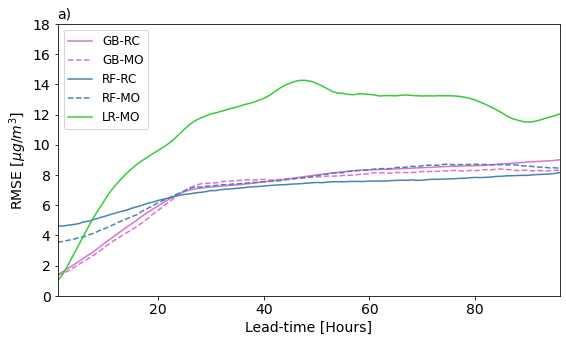

In [237]:
plt.figure(figsize=(9,5),facecolor='white')

colors=['orchid','orchid','steelblue','steelblue','limegreen']
lss = ['solid','--','solid','--','solid','--']
for imethod,method in enumerate(['GB_CH','GB_MO','RF_CH','RF_MO','LR_MO']):
    temp_df = rmse_df[rmse_df['method']==method].iloc[:,:96].dropna()
    
#     for i in range(len(temp_df)):
#         plt.plot(temp_df.values[i],color=colors[imethod],alpha=0.05)
    plt.plot(np.arange(1,97),np.mean(temp_df.values,axis=0),
             color=colors[imethod],ls=lss[imethod],label=method.replace('_','-').replace('CH','RC'))
plt.ylim(0,18)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'RMSE [$\mu g / m^3$]',fontsize=14)
plt.xlim(1,96)
plt.xlabel('Lead-time [Hours]',fontsize=14)
plt.title('a)',loc='left',fontsize=14)
plt.savefig('Figures/RMSE_v3.png',bbox_inches='tight')


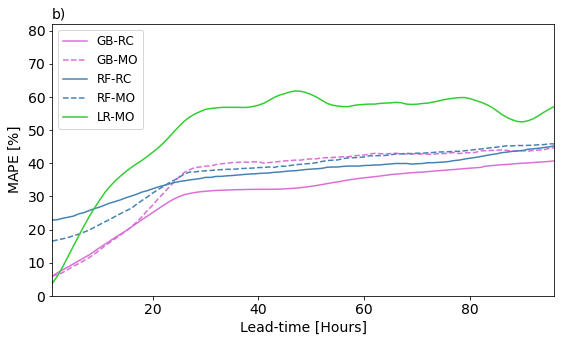

In [238]:
plt.figure(figsize=(9,5), facecolor='white')

colors=['orchid','orchid','steelblue','steelblue','limegreen']
lss = ['solid','--','solid','--','solid','--']
for imethod,method in enumerate(['GB_CH','GB_MO','RF_CH','RF_MO','LR_MO']):
    temp_df = mape_df[mape_df['method']==method].iloc[:,:96].dropna()
    
#     for i in range(len(temp_df)):
#         plt.plot(temp_df.values[i],color=colors[imethod],alpha=0.05)
    plt.plot(np.arange(1,97),np.mean(temp_df.values,axis=0),
             color=colors[imethod],ls=lss[imethod],label=method.replace('_','-').replace('CH','RC'))
plt.ylim(0,82)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'MAPE [$\%$]',fontsize=14)
plt.xlim(1,96)
plt.xlabel('Lead-time [Hours]',fontsize=14)
plt.title('b)',loc='left',fontsize=14)
plt.savefig('Figures/MAPE_v3.png',bbox_inches='tight')


In [218]:
# plt.figure(figsize=(9,5))

# colors=['orchid','orchid','steelblue','steelblue','limegreen']
# lss = ['solid','--','solid','--','solid','--']
# for imethod,method in enumerate(['GB_CH','GB_MO','RF_CH','RF_MO','LR_MO']):
#     temp_df = mape_df[mape_df['method']==method].iloc[:,:96].dropna()
    
# #     for i in range(len(temp_df)):
# #         plt.plot(temp_df.values[i],color=colors[imethod],alpha=0.05)
#     plt.plot(np.arange(1,97),np.mean(temp_df.values,axis=0),
#              color=colors[imethod],ls=lss[imethod],label=method.replace('_','-'))
# plt.ylim(0,82)
# plt.legend(fontsize=12)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# plt.ylabel(r'MAPE [$\%$]',fontsize=14)
# plt.xlim(1,96)
# plt.xlabel('Lead-time [Hours]',fontsize=14)
# plt.title('b)',loc='left',fontsize=14)
# # plt.savefig('Figures/MAPE_v2.png',bbox_inches='tight')

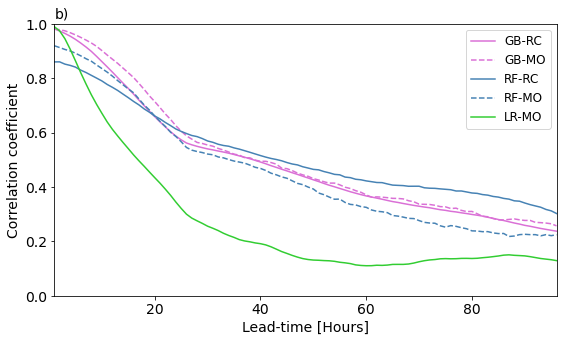

In [245]:
plt.figure(figsize=(9,5), facecolor='white')

colors=['orchid','orchid','steelblue','steelblue','limegreen']
lss = ['solid','--','solid','--','solid','--']
for imethod,method in enumerate(['GB_CH','GB_MO','RF_CH','RF_MO','LR_MO']):
    temp_df = corr_df[corr_df['method']==method].iloc[:,:96].dropna()
    
#     for i in range(len(temp_df)):
#         plt.plot(temp_df.values[i],color=colors[imethod],alpha=0.05)
    plt.plot(np.arange(1,97),np.mean(temp_df.values,axis=0),
             color=colors[imethod],ls=lss[imethod],label=method.replace('_','-').replace('CH','RC'))
plt.ylim(0,1)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'Correlation coefficient',fontsize=14)
plt.xlim(1,96)
plt.xlabel('Lead-time [Hours]',fontsize=14)
plt.title('b)',loc='left',fontsize=14)
plt.savefig('Figures/CORR_v3.png',bbox_inches='tight')



In [221]:
from mycolorpy import colorlist as mcp
import numpy as np


In [224]:
# plt.figure(figsize=(9,5))

# colors=mcp.gen_color(cmap="gist_ncar",n=20)
# lss = ['solid','--','solid','--','solid','--']

# for istation,station in enumerate(mape_df[mape_df['method']==method].dropna()['station'].values):
#     temp_df = mape_df[mape_df['station']==station].dropna()
#     temp_values = temp_df.mean(axis=0).values#[:-2]
#     plt.plot(np.arange(1,97),temp_values/1.15,label=station,color=colors[istation])

# plt.legend(fontsize=12,ncol=3, loc=4)
# plt.xticks(fontsize=14)
# plt.yticks([10,20,30,40,50,60],fontsize=14)

# plt.ylabel(r'MAPE [$\%$]',fontsize=14)
# plt.xlim(1,96)
# plt.xlabel('Lead-time [Hours]',fontsize=14)
# #plt.title('c)',loc='left',fontsize=14)
# plt.ylim(-10,45)
# # plt.savefig('Figures/MAPE_stations.png',bbox_inches='tight')


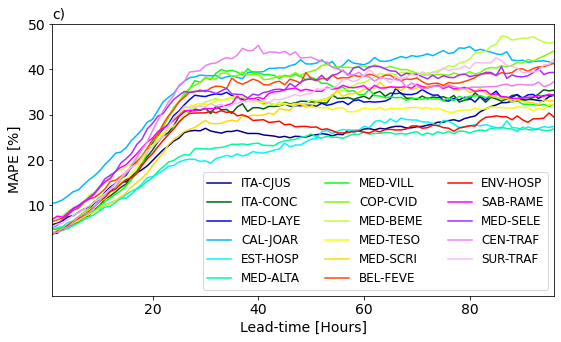

In [240]:
plt.figure(figsize=(9,5), facecolor='white')

colors=mcp.gen_color(cmap="gist_ncar",n=20)
lss = ['solid','--','solid','--','solid','--']

for istation,station in enumerate(mape_df[mape_df['method']==method].dropna()['station'].values):
    if (station=='BAR-TORR')|(station=='MED-ARAN'):
        continue
    temp_df = mape_df[(mape_df['station']==station)&(mape_df['method']=='GB_MO')].dropna()
    temp_values = temp_df.min(axis=0).values[:-2]
    plt.plot(np.arange(1,97),temp_values/1.15,label=station,color=colors[istation])

plt.legend(fontsize=12,ncol=3, loc=4)
plt.xticks(fontsize=14)
plt.yticks([10,20,30,40,50,60],fontsize=14)

plt.ylabel(r'MAPE [$\%$]',fontsize=14)
plt.xlim(1,96)
plt.xlabel('Lead-time [Hours]',fontsize=14)
plt.title('c)',loc='left',fontsize=14)
plt.ylim(-10,50)
plt.savefig('Figures/MAPE_stations_v3.png',bbox_inches='tight')


# validate CAMS PM2.5

In [260]:
station_cams = []
mae_cams = []
mape_cams = []
rmse_cams = []
corr_cams = []

station = 'EST-HOSP'
coor_esta= pd.read_csv("/var/data1/AQ_Forecast_DATA/historic/PM25/CoordenadasEstaciones.csv", index_col= "Nombre")

for station in ["EST-HOSP", "MED-ALTA", "MED-VILL"]:
    print(station)
    X = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_X.npy',allow_pickle=True)
    Y_validation = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_Y_validation.npy',allow_pickle=True)
    Y_cams = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_Y_cams.npy',allow_pickle=True)
    dates = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_dates.npy',allow_pickle=True)

#             mae_df.append([mean_absolute_error(Y_validation[:,i],Y_predicted[:,i]) for i in range(96)])
#             mape_df.append([mean_absolute_percentage_error(Y_validation[:,i],Y_predicted[:,i]) for i in range(96)])
#             rmse_df.append([np.sqrt(mean_squared_error(Y_validation[:,i],Y_predicted[:,i])) for i in range(96)])
    station_cams.append(station)
    mae_cams.append([mod_mae(Y_validation[:,i],Y_cams[:,i]) for i in range(96)])
    mape_cams.append([mod_mape(Y_validation[:,i],Y_cams[:,i]) for i in range(96)])
    rmse_cams.append([mod_rmse(Y_validation[:,i],Y_cams[:,i]) for i in range(96)])

    corr_cams.append([np.corrcoef(Y_validation[:,i],Y_cams[:,i])[0,1] for i in range(96)])

EST-HOSP
MED-ALTA
MED-VILL


# Scatters ejemplo

MED-SELE
MED-LAYE
SUR-TRAF


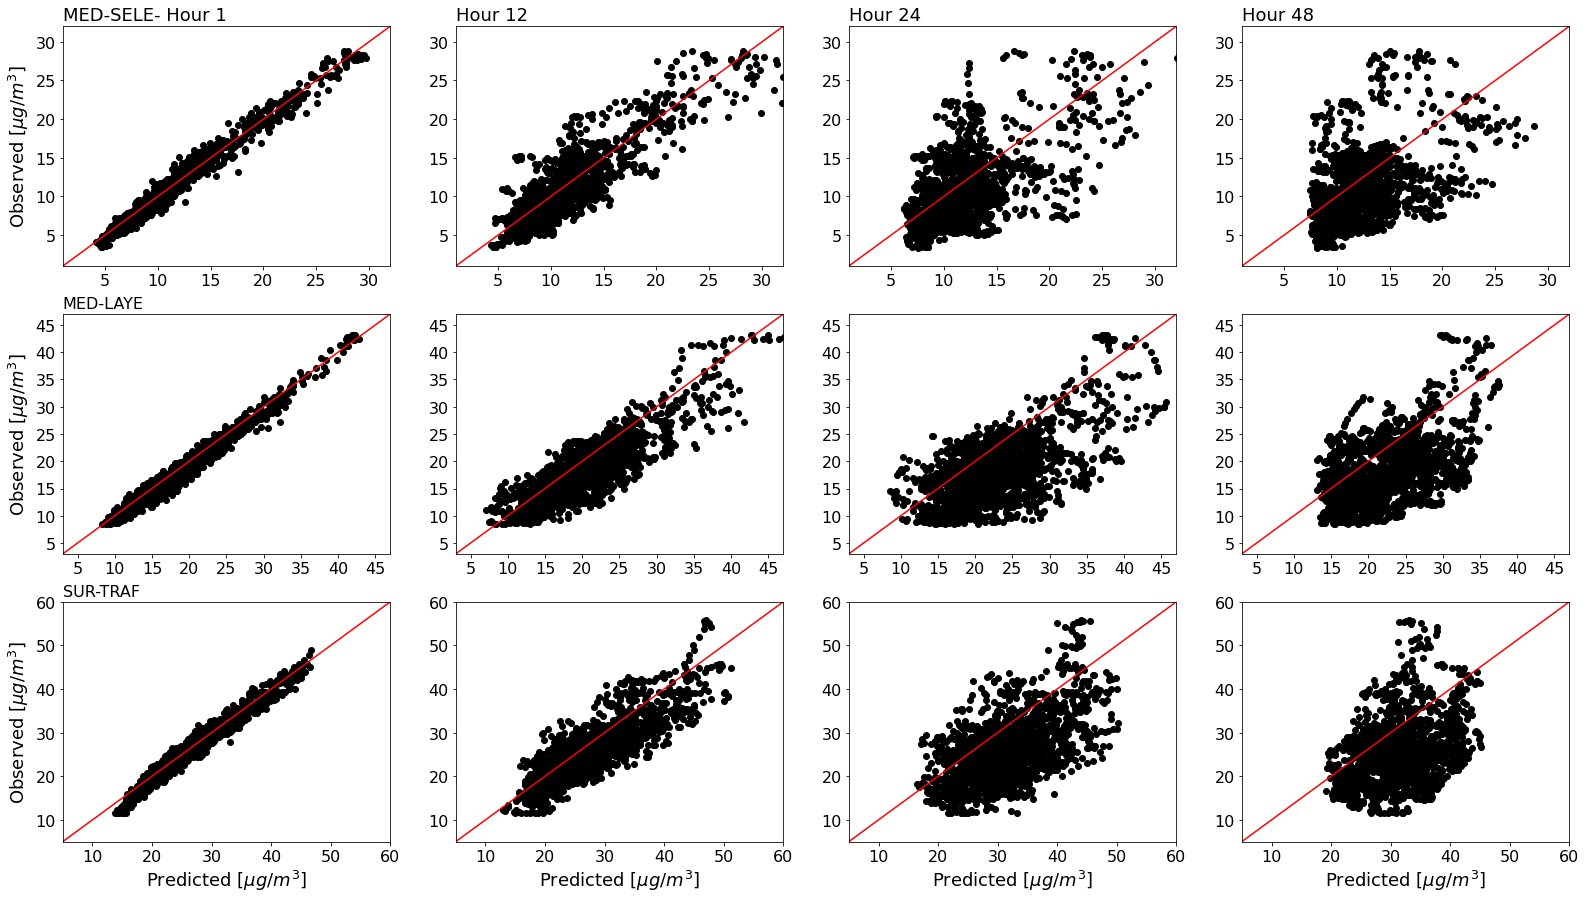

In [272]:
fig = plt.figure(figsize=(27,15))
ylims = [(1,32),(3,47),(5,60)]

for istation,station in enumerate(['MED-SELE','MED-LAYE','SUR-TRAF']):
    print(station)
    X = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_X.npy',allow_pickle=True)
    Y_validation = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_Y_validation.npy',allow_pickle=True)
    dates = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_dates.npy',allow_pickle=True)
    scaler_x = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_X.scl')
    scaler_y = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_Y.scl')
    X_scaled = scaler_x.transform(X)

    model_name = 'GB_MO'
    estimator_temp = joblib.load('/var/data1/AQ_Forecast_DATA/trained_estimators_v3/'+station+'_'+model_name+'.mdl')
    Y_predicted_scaled = estimator_temp.predict(X_scaled)
    Y_predicted = scaler_y.inverse_transform(Y_predicted_scaled)

    for i,leadtime in enumerate([1,12,24,48]):
        ax = fig.add_subplot(3,4,(i+1)+istation*4)
        ax.scatter(Y_predicted[:,leadtime-1],Y_validation[:,leadtime-1],color='k')
        ax.plot([0,100],[0,100],color='red')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        if (istation==0)&(i>0):
            plt.title(['Hour 12','Hour 24','Hour 48'][i-1],fontsize=18,loc='left')
        if i%4==0:
            if istation==0:
                plt.title(station + '- Hour 1',fontsize=18,loc='left')
            else:
                plt.title(station,fontsize=16,loc='left')
            plt.ylabel(r'Observed [$\mu g / m^3$]',fontsize=18)
        if istation==2:
            plt.xlabel(r'Predicted [$\mu g / m^3$]',fontsize=18)
            
        ax.set_ylim(*ylims[istation])
        ax.set_xlim(*ylims[istation])
plt.savefig('Figures/ExamplesScatter_v3.png',bbox_inches='tight')

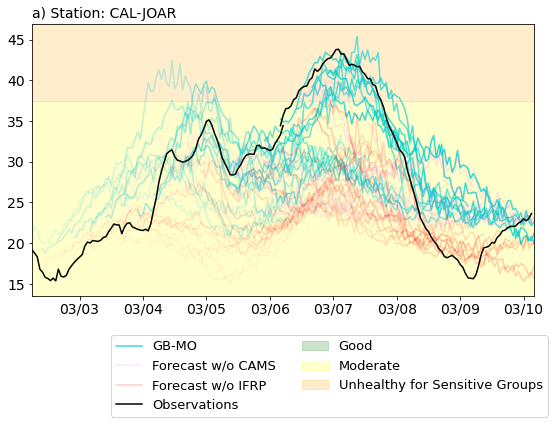

In [385]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

station = 'CAL-JOAR'
model_name='GB_MO'

dic_predictions = {}

estimator_temp = joblib.load('/var/data1/AQ_Forecast_DATA/trained_estimators_v3/'+station+'_'+model_name+'.mdl')
scaler_x = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_X.scl')
scaler_y = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_Y.scl')

X = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_X.npy',allow_pickle=True)
X_scaled = scaler_x.transform(X)
Y_predicted_scaled = estimator_temp.predict(X_scaled)
Y_predicted = scaler_y.inverse_transform(Y_predicted_scaled)
Y_validation = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+
    station+'_Y_validation.npy',allow_pickle=True)
    
dates = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+
    station+'_dates.npy',allow_pickle=True)

where_CAMS = slice(48,81)
where_ifrp = slice(180,213)

estimator_temp = joblib.load('/var/data1/AQ_Forecast_DATA/trained_estimators_v3/'+station+'_'+model_name+'.mdl')
scaler_x = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_X.scl')
scaler_y = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_Y.scl')

X = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_X.npy',allow_pickle=True)
X_scaled = scaler_x.transform(X)
X_scaled[:,where_CAMS] = 0
Y_predicted_scaled = estimator_temp.predict(X_scaled)
Y_predicted_nocams = scaler_y.inverse_transform(Y_predicted_scaled)

estimator_temp = joblib.load('/var/data1/AQ_Forecast_DATA/trained_estimators_v3/'+station+'_'+model_name+'.mdl')
scaler_x = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_X.scl')
scaler_y = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_Y.scl')

X = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_X.npy',allow_pickle=True)
X_scaled = scaler_x.transform(X)
X_scaled[:,where_ifrp] = 0
Y_predicted_scaled = estimator_temp.predict(X_scaled)
Y_predicted_noifrp = scaler_y.inverse_transform(Y_predicted_scaled)

dates = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+
    station+'_dates.npy',allow_pickle=True)

# iloc = 685
iloc = 685

fig = plt.figure(figsize=(9,5))
ax=fig.add_subplot(111)
index = pd.to_datetime(dates[iloc-1:iloc+95])

for ilag,lag in enumerate(np.arange(-96,24,6)):
    if ilag==18:
        plt.plot(index+dt.timedelta(hours=float(lag)),Y_predicted[iloc+lag],
                 color='darkturquoise',alpha=((np.arange(-96,24,6)+114)/132)[ilag]*0.8,
                label='GB-MO')
    else:
        plt.plot(index+dt.timedelta(hours=float(lag)),Y_predicted[iloc+lag],
                 color='darkturquoise',alpha=((np.arange(-96,24,6)+114)/132)[ilag]*0.8)
for ilag,lag in enumerate(np.arange(-96,24,6)):
    if ilag==18:
        plt.plot(index+dt.timedelta(hours=float(lag)),Y_predicted_nocams[iloc+lag],
                 color='violet',alpha=((np.arange(-96,24,6)+114)/132)[ilag]*0.2,
                label='Forecast w/o CAMS')
    else:
        plt.plot(index+dt.timedelta(hours=float(lag)),Y_predicted_nocams[iloc+lag],
                 color='violet',alpha=((np.arange(-96,24,6)+114)/132)[ilag]*0.2)

for ilag,lag in enumerate(np.arange(-96,24,6)):
    if ilag==18:
        plt.plot(index+dt.timedelta(hours=float(lag)),Y_predicted_noifrp[iloc+lag],
                 color='red',alpha=((np.arange(-96,24,6)+114)/132)[ilag]*0.2,
                label='Forecast w/o IFRP')
    else:
        plt.plot(index+dt.timedelta(hours=float(lag)),Y_predicted_noifrp[iloc+lag],
                 color='red',alpha=((np.arange(-96,24,6)+114)/132)[ilag]*0.2)

plt.plot(index,Y_validation[iloc],color='k')
#'03/06/2021 06 Forecast'
index = pd.to_datetime(dates[iloc-95:iloc+1])
plt.plot(index,Y_validation[iloc-95],color='k',label='Observations')
# plt.axvline(dates[iloc-1],color='k',ls = '--')
limites_ica = {'Good':(0,12.5),
              'Moderate':(12.5,37.5),
              'Unhealthy for Sensitive Groups':(37.5,55.5),
              'Unhealthy':(55.5,150.5),
              'Very Unhealthy':(150.5,250.5),
              'Hazardous':(250.5,500)}

colores_ica = ['green','yellow','orange','red','purple','brown']

ylim = plt.gca().get_ylim()

# for i in range(len(colores_ica)):
for i in [0,1,2]:
    plt.fill_between([dates[iloc]-dt.timedelta(hours=95),dates[iloc]+dt.timedelta(hours=95)],
                limites_ica[list(limites_ica.keys())[i]][0],
                limites_ica[list(limites_ica.keys())[i]][1],
                alpha=0.2,color=colores_ica[i],label=list(limites_ica.keys())[i])

    
plt.ylim(ylim[0], ylim[1])
# plt.legend(ncol=2,bbox_to_anchor=(0.98, -0.12),fontsize=13)
plt.xlim(dates[iloc]-dt.timedelta(hours=95),dates[iloc]+dt.timedelta(hours=95))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Define the date format
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)
# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.legend(ncol=2,bbox_to_anchor=(1.04, -0.12),fontsize=13)


plt.title(f'a) Station: {station}',loc='left',fontsize=14)
plt.savefig(f'Figures/Example_{station}_withlegend',bbox_inches='tight')

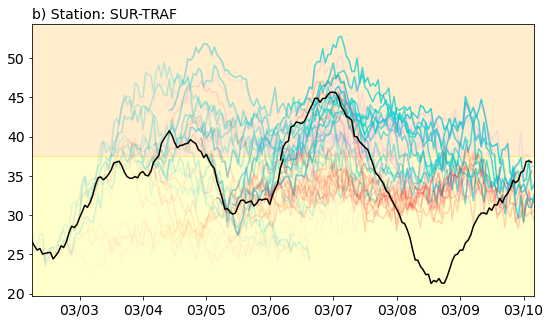

In [274]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

station = 'SUR-TRAF'
model_name='GB_MO'

dic_predictions = {}

estimator_temp = joblib.load('/var/data1/AQ_Forecast_DATA/trained_estimators_v3/'+station+'_'+model_name+'.mdl')
scaler_x = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_X.scl')
scaler_y = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_Y.scl')

X = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_X.npy',allow_pickle=True)
X_scaled = scaler_x.transform(X)
Y_predicted_scaled = estimator_temp.predict(X_scaled)
Y_predicted = scaler_y.inverse_transform(Y_predicted_scaled)
Y_validation = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+
    station+'_Y_validation.npy',allow_pickle=True)
    
dates = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+
    station+'_dates.npy',allow_pickle=True)

where_CAMS = slice(48,81)
where_ifrp = slice(180,213)

estimator_temp = joblib.load('/var/data1/AQ_Forecast_DATA/trained_estimators_v3/'+station+'_'+model_name+'.mdl')
scaler_x = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_X.scl')
scaler_y = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_Y.scl')

X = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_X.npy',allow_pickle=True)
X_scaled = scaler_x.transform(X)
X_scaled[:,where_CAMS] = 0
Y_predicted_scaled = estimator_temp.predict(X_scaled)
Y_predicted_nocams = scaler_y.inverse_transform(Y_predicted_scaled)

estimator_temp = joblib.load('/var/data1/AQ_Forecast_DATA/trained_estimators_v3/'+station+'_'+model_name+'.mdl')
scaler_x = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_X.scl')
scaler_y = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_Y.scl')

X = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_X.npy',allow_pickle=True)
X_scaled = scaler_x.transform(X)
X_scaled[:,where_ifrp] = 0
Y_predicted_scaled = estimator_temp.predict(X_scaled)
Y_predicted_noifrp = scaler_y.inverse_transform(Y_predicted_scaled)

dates = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+
    station+'_dates.npy',allow_pickle=True)

# iloc = 685
iloc = 685

fig = plt.figure(figsize=(9,5))
ax=fig.add_subplot(111)
index = pd.to_datetime(dates[iloc-1:iloc+95])

for ilag,lag in enumerate(np.arange(-96,24,6)):
    if ilag==0:
        plt.plot(index+dt.timedelta(hours=float(lag)),Y_predicted[iloc+lag],
                 color='darkturquoise',alpha=((np.arange(-96,24,6)+114)/132)[ilag]*0.8,
                label='GB-MO')
    else:
        plt.plot(index+dt.timedelta(hours=float(lag)),Y_predicted[iloc+lag],
                 color='darkturquoise',alpha=((np.arange(-96,24,6)+114)/132)[ilag]*0.8)
for ilag,lag in enumerate(np.arange(-96,24,6)):
    if ilag==0:
        plt.plot(index+dt.timedelta(hours=float(lag)),Y_predicted_nocams[iloc+lag],
                 color='violet',alpha=((np.arange(-96,24,6)+114)/132)[ilag]*0.2,
                label='Forecast w/o CAMS')
    else:
        plt.plot(index+dt.timedelta(hours=float(lag)),Y_predicted_nocams[iloc+lag],
                 color='violet',alpha=((np.arange(-96,24,6)+114)/132)[ilag]*0.2)

for ilag,lag in enumerate(np.arange(-96,24,6)):
    if ilag==0:
        plt.plot(index+dt.timedelta(hours=float(lag)),Y_predicted_noifrp[iloc+lag],
                 color='red',alpha=((np.arange(-96,24,6)+114)/132)[ilag]*0.2,
                label='Forecast w/o IFRP')
    else:
        plt.plot(index+dt.timedelta(hours=float(lag)),Y_predicted_noifrp[iloc+lag],
                 color='red',alpha=((np.arange(-96,24,6)+114)/132)[ilag]*0.2)

plt.plot(index,Y_validation[iloc],color='k')
#'03/06/2021 06 Forecast'
index = pd.to_datetime(dates[iloc-95:iloc+1])
plt.plot(index,Y_validation[iloc-95],color='k',label='Observations')
# plt.axvline(dates[iloc-1],color='k',ls = '--')
limites_ica = {'Good':(0,12.5),
              'Moderate':(12.5,37.5),
              'Unhealthy for Sensitive Groups':(37.5,55.5),
              'Unhealthy':(55.5,150.5),
              'Very Unhealthy':(150.5,250.5),
              'Hazardous':(250.5,500)}

colores_ica = ['green','yellow','orange','red','purple','brown']

ylim = plt.gca().get_ylim()

# for i in range(len(colores_ica)):
for i in [0,1,2]:
    plt.fill_between([dates[iloc]-dt.timedelta(hours=95),dates[iloc]+dt.timedelta(hours=95)],
                limites_ica[list(limites_ica.keys())[i]][0],
                limites_ica[list(limites_ica.keys())[i]][1],
                alpha=0.2,color=colores_ica[i],label=list(limites_ica.keys())[i])

    
plt.ylim(ylim[0], ylim[1])
# plt.legend(ncol=2,bbox_to_anchor=(0.98, -0.12),fontsize=13)
plt.xlim(dates[iloc]-dt.timedelta(hours=95),dates[iloc]+dt.timedelta(hours=95))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Define the date format
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)
# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

plt.title(f'b) Station: {station}',loc='left',fontsize=14)
plt.savefig(f'Figures/Example_{station}',bbox_inches='tight')

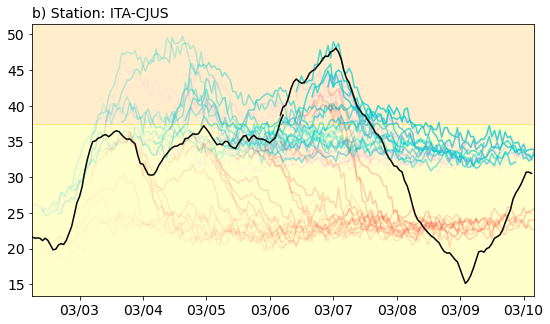

In [381]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

station = 'ITA-CJUS'
model_name='GB_MO'

dic_predictions = {}

estimator_temp = joblib.load('/var/data1/AQ_Forecast_DATA/trained_estimators_v3/'+station+'_'+model_name+'.mdl')
scaler_x = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_X.scl')
scaler_y = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_Y.scl')

X = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_X.npy',allow_pickle=True)
X_scaled = scaler_x.transform(X)
Y_predicted_scaled = estimator_temp.predict(X_scaled)
Y_predicted = scaler_y.inverse_transform(Y_predicted_scaled)
Y_validation = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+
    station+'_Y_validation.npy',allow_pickle=True)
    
dates = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+
    station+'_dates.npy',allow_pickle=True)

where_CAMS = slice(48,81)
where_ifrp = slice(180,213)

estimator_temp = joblib.load('/var/data1/AQ_Forecast_DATA/trained_estimators_v3/'+station+'_'+model_name+'.mdl')
scaler_x = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_X.scl')
scaler_y = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_Y.scl')

X = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_X.npy',allow_pickle=True)
X_scaled = scaler_x.transform(X)
X_scaled[:,where_CAMS] = 0
Y_predicted_scaled = estimator_temp.predict(X_scaled)
Y_predicted_nocams = scaler_y.inverse_transform(Y_predicted_scaled)

estimator_temp = joblib.load('/var/data1/AQ_Forecast_DATA/trained_estimators_v3/'+station+'_'+model_name+'.mdl')
scaler_x = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_X.scl')
scaler_y = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_Y.scl')

X = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_X.npy',allow_pickle=True)
X_scaled = scaler_x.transform(X)
X_scaled[:,where_ifrp] = 0
Y_predicted_scaled = estimator_temp.predict(X_scaled)
Y_predicted_noifrp = scaler_y.inverse_transform(Y_predicted_scaled)

dates = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+
    station+'_dates.npy',allow_pickle=True)

# iloc = 685
iloc = 685

fig = plt.figure(figsize=(9,5))
ax=fig.add_subplot(111)
index = pd.to_datetime(dates[iloc-1:iloc+95])

for ilag,lag in enumerate(np.arange(-96,24,6)):
    if ilag==0:
        plt.plot(index+dt.timedelta(hours=float(lag)),Y_predicted[iloc+lag],
                 color='darkturquoise',alpha=((np.arange(-96,24,6)+114)/132)[ilag]*0.8,
                label='GB-MO')
    else:
        plt.plot(index+dt.timedelta(hours=float(lag)),Y_predicted[iloc+lag],
                 color='darkturquoise',alpha=((np.arange(-96,24,6)+114)/132)[ilag]*0.8)
for ilag,lag in enumerate(np.arange(-96,24,6)):
    if ilag==0:
        plt.plot(index+dt.timedelta(hours=float(lag)),Y_predicted_nocams[iloc+lag],
                 color='violet',alpha=((np.arange(-96,24,6)+114)/132)[ilag]*0.2,
                label='Forecast w/o CAMS')
    else:
        plt.plot(index+dt.timedelta(hours=float(lag)),Y_predicted_nocams[iloc+lag],
                 color='violet',alpha=((np.arange(-96,24,6)+114)/132)[ilag]*0.2)

for ilag,lag in enumerate(np.arange(-96,24,6)):
    if ilag==0:
        plt.plot(index+dt.timedelta(hours=float(lag)),Y_predicted_noifrp[iloc+lag],
                 color='red',alpha=((np.arange(-96,24,6)+114)/132)[ilag]*0.2,
                label='Forecast w/o IFRP')
    else:
        plt.plot(index+dt.timedelta(hours=float(lag)),Y_predicted_noifrp[iloc+lag],
                 color='red',alpha=((np.arange(-96,24,6)+114)/132)[ilag]*0.2)

plt.plot(index,Y_validation[iloc],color='k')
#'03/06/2021 06 Forecast'
index = pd.to_datetime(dates[iloc-95:iloc+1])
plt.plot(index,Y_validation[iloc-95],color='k',label='Observations')
# plt.axvline(dates[iloc-1],color='k',ls = '--')
limites_ica = {'Good':(0,12.5),
              'Moderate':(12.5,37.5),
              'Unhealthy for Sensitive Groups':(37.5,55.5),
              'Unhealthy':(55.5,150.5),
              'Very Unhealthy':(150.5,250.5),
              'Hazardous':(250.5,500)}

colores_ica = ['green','yellow','orange','red','purple','brown']

ylim = plt.gca().get_ylim()

# for i in range(len(colores_ica)):
for i in [0,1,2]:
    plt.fill_between([dates[iloc]-dt.timedelta(hours=95),dates[iloc]+dt.timedelta(hours=95)],
                limites_ica[list(limites_ica.keys())[i]][0],
                limites_ica[list(limites_ica.keys())[i]][1],
                alpha=0.2,color=colores_ica[i],label=list(limites_ica.keys())[i])

    
plt.ylim(ylim[0], ylim[1])
# plt.legend(ncol=2,bbox_to_anchor=(0.98, -0.12),fontsize=13)
plt.xlim(dates[iloc]-dt.timedelta(hours=95),dates[iloc]+dt.timedelta(hours=95))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Define the date format
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)
# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

plt.title(f'b) Station: {station}',loc='left',fontsize=14)
plt.savefig(f'Figures/Example_{station}',bbox_inches='tight')

## error por horas

In [275]:
model_name='GB_MO'
CD_ERROR = []
CD_MAPE = []

for station in stations:
    estimator_temp = joblib.load('/var/data1/AQ_Forecast_DATA/trained_estimators_v3/'+station+'_'+model_name+'.mdl')
    scaler_x = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_X.scl')
    scaler_y = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_Y.scl')

    X = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_X.npy',allow_pickle=True)
    X_scaled = scaler_x.transform(X)
    Y_predicted_scaled = estimator_temp.predict(X_scaled)
    Y_predicted = scaler_y.inverse_transform(Y_predicted_scaled)
    Y_validation = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+
        station+'_Y_validation.npy',allow_pickle=True)
    
    dates = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+
    station+'_dates.npy',allow_pickle=True)
    df_hours = pd.DataFrame(np.array([(pd.to_datetime(dates) + dt.timedelta(hours=i)).hour for i in range(1,97)]).T, 
                        index=dates,columns = np.arange(1,97))


    error_matrix = (Y_validation - Y_predicted)**2
    mape_matrix = abs((Y_validation - Y_predicted) * 100 / Y_predicted)

    cd_error = np.zeros([24,96])
    cd_mape = np.zeros([24,96])
    for leadtime in range(1,97):
        error_temp = error_matrix[:,leadtime-1]
        mape_temp = mape_matrix[:,leadtime-1]
        for hour in range(0,24):
            error_temp_hour = error_temp[np.where(df_hours[leadtime]==hour)[0]]
            mape_temp_hour = mape_temp[np.where(df_hours[leadtime]==hour)[0]]
            cd_error[hour,leadtime-1] = np.mean(np.sqrt(error_temp_hour))
            cd_mape[hour,leadtime-1] = np.mean(mape_temp_hour)

    CD_ERROR.append(cd_error)
    CD_MAPE.append(cd_mape)

In [276]:
CD_ERROR = np.array(CD_ERROR)
CD_MAPE = np.array(CD_MAPE)

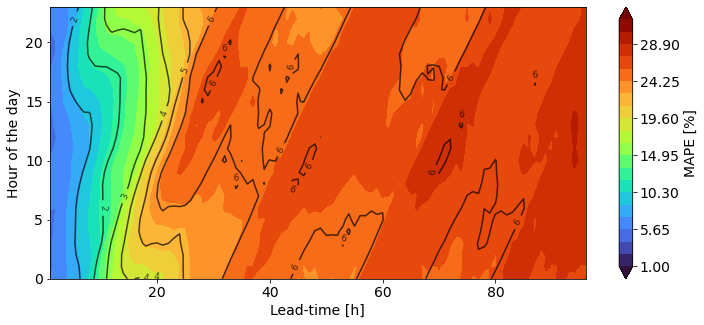

In [277]:
plt.close('all')
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
mini = 1
maxi = 32
intervals = 21
bounds=np.linspace(mini,maxi,intervals)
CS = plt.contourf(np.arange(1,97),np.arange(0,24),np.mean(CD_MAPE,axis=0),vmin=mini,vmax=maxi,cmap='turbo', 
                  levels = bounds,extend='both')
CT = plt.contour(np.arange(1,97),np.arange(0,24),np.mean(CD_ERROR,axis=0),7,colors='k',alpha = 0.7)
ax.clabel(CT, fontsize=9, inline=1,fmt = '%1.0f')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Lead-time [h]',fontsize=14)
plt.ylabel('Hour of the day',fontsize=14)
# plt.title(model_name+' forecast - '+station,fontsize=16)
cbar = plt.colorbar(CS)
cbar.set_label('MAPE [%]',fontsize=14)
cbar.ax.tick_params(labelsize=14) 
plt.savefig('Figures/CD_Error',bbox_inches='tight')

# Features importance

In [278]:
from mycolorpy import colorlist as mcp

In [279]:
model_name='GB_MO'

In [280]:
stations = ["ITA-CJUS", "ITA-CONC", "MED-LAYE", "CAL-JOAR", "EST-HOSP", "MED-ALTA", "MED-VILL",
            "BAR-TORR", "COP-CVID", "MED-BEME", "MED-TESO", "MED-SCRI", "MED-ARAN", "BEL-FEVE", "ENV-HOSP", 
            "SAB-RAME", "MED-SELE","CEN-TRAF","SUR-TRAF"]

In [281]:
importances_full = []
for station in stations:
    estimator_temp = joblib.load('/var/data1/AQ_Forecast_DATA/trained_estimators_v3/'+station+'_'+model_name+'.mdl')
    importances = np.zeros([269,96])
    for leadtime in range(1,97):
        importances[:,leadtime-1] = estimator_temp.estimators_[leadtime-1].feature_importances_
    importances_full.append(importances)

In [282]:
importances_full = np.array(importances_full)

In [283]:
for i in range(len(importances_full)):
    for j in range(importances_full.shape[2]):
        importances_full[i][:,j] = importances_full[i][:,j]/np.sum(importances_full[i][:,j])

In [284]:
mean_importance = np.mean(importances_full,axis=0)

df_importances = pd.DataFrame()

df_importances['Past PM2.5 concentrations'] = np.sum(mean_importance[0:48],axis=0)
df_importances['AOD-CAMS'] = np.sum(mean_importance[48:81],axis=0)
df_importances['TCC-GFS'] = np.sum(mean_importance[81:114],axis=0)
df_importances['PRATE-GFS'] = np.sum(mean_importance[114:147],axis=0)
df_importances['HPBL-GFS'] = np.sum(mean_importance[147:180],axis=0)
df_importances['IFRP'] = np.sum(mean_importance[180:213],axis=0)
df_importances['Day of the week'] = np.sum(mean_importance[213:221],axis=0)
df_importances['Hour of the day'] = np.sum(mean_importance[221:269],axis=0)

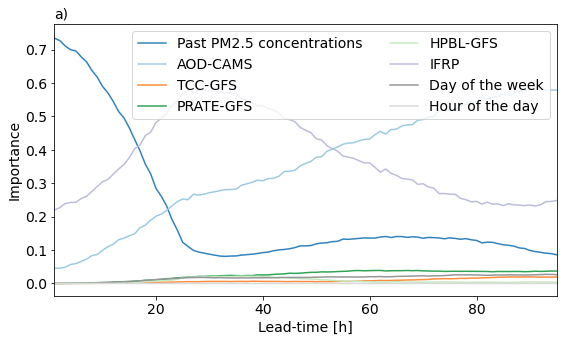

In [285]:
colors=mcp.gen_color(cmap="tab20c",n=8)

plt.figure(figsize=(9,5))
for ikey,key in enumerate(list(df_importances.keys())):
    plt.plot(df_importances[key],label=key,color=colors[ikey])
plt.ylabel('Importance',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Lead-time [h]',fontsize=14)
plt.xlim(1,95)
# plt.ylim(0,350)
plt.title('a)',loc='left',fontsize=14)
plt.legend(fontsize=14,ncol=2)#,bbox_to_anchor=(1.,1.03))
plt.savefig('Figures/FeatureImportances_v3',bbox_inches='tight')

# Para cada estación

In [286]:
s=-1

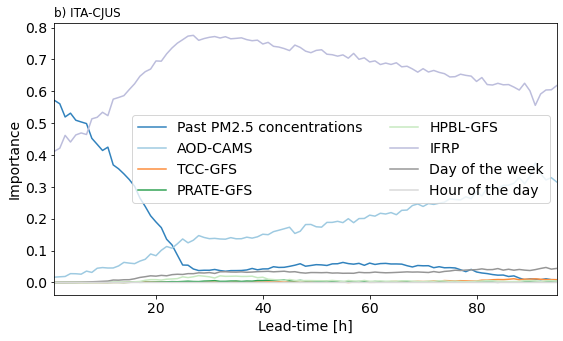

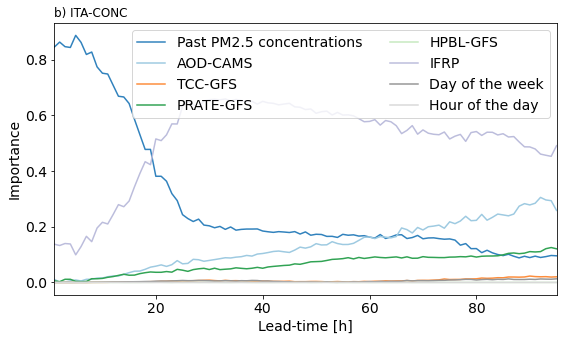

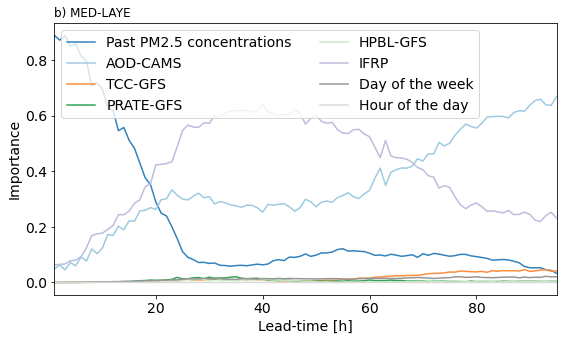

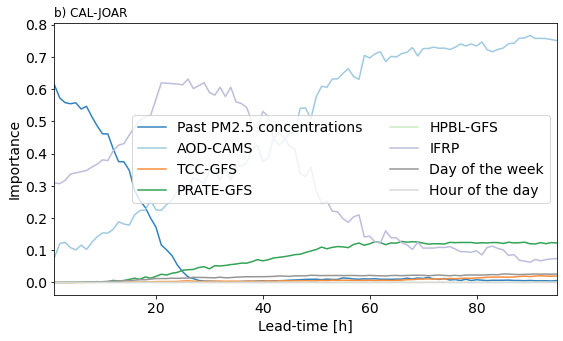

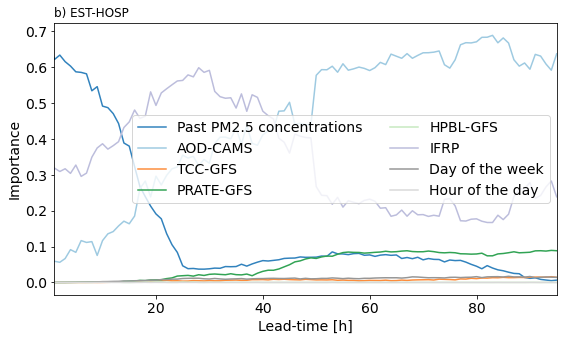

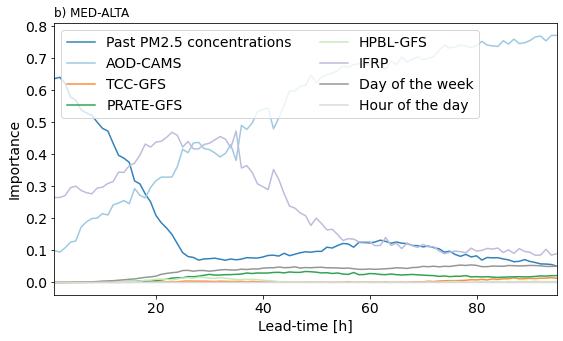

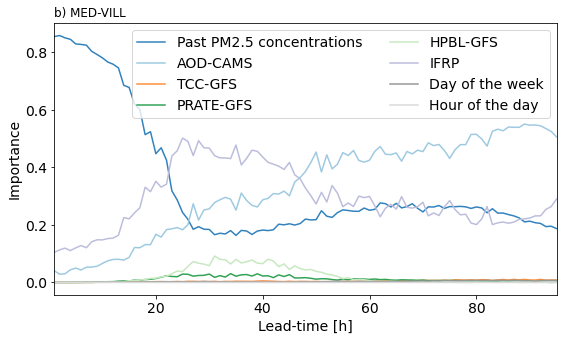

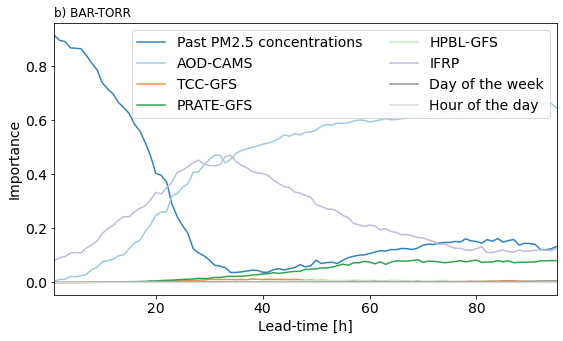

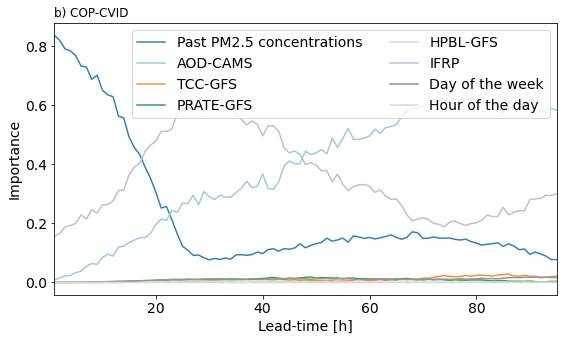

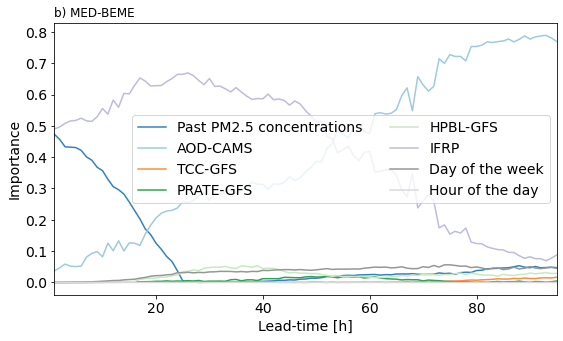

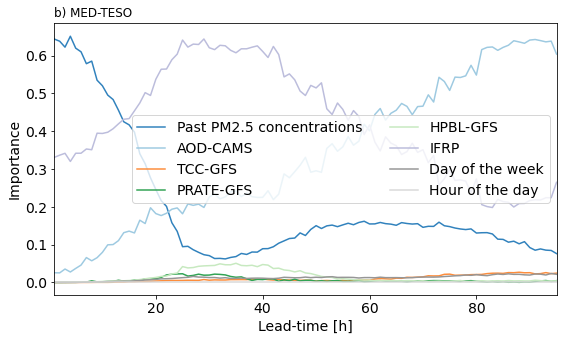

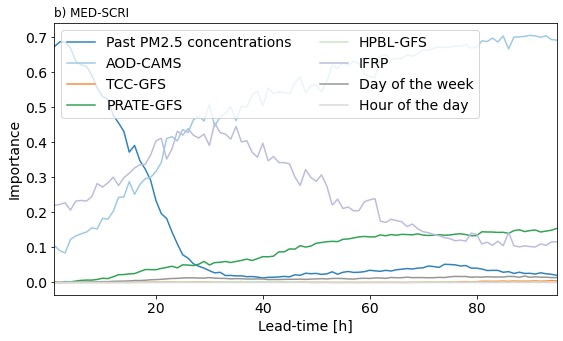

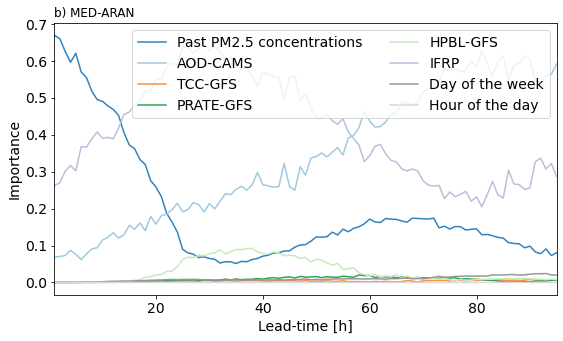

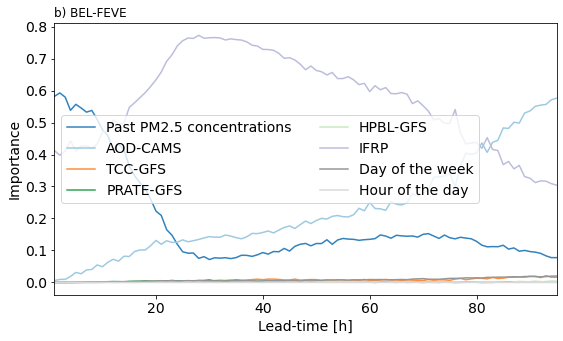

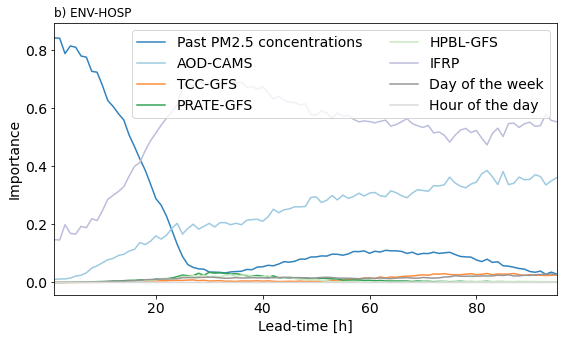

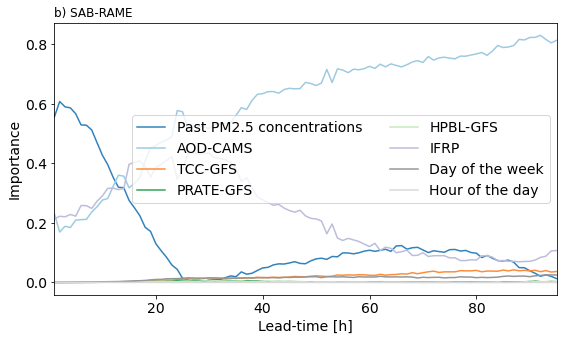

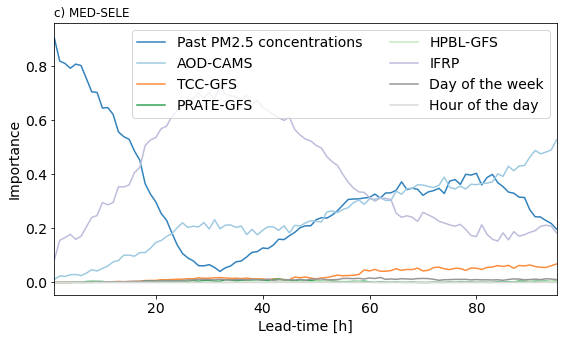

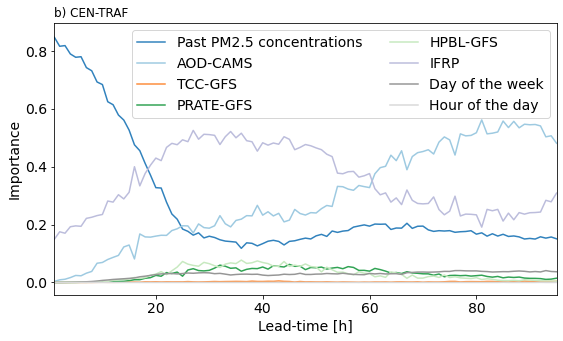

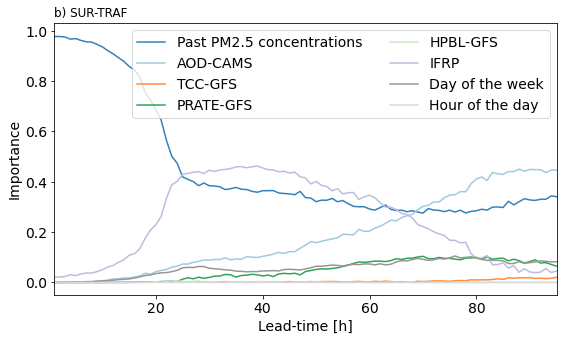

In [287]:
for s in range(len(importances_full)):
    mean_importance = importances_full[s]

    df_importances = pd.DataFrame()

    df_importances['Past PM2.5 concentrations'] = np.sum(mean_importance[0:48],axis=0)
    df_importances['AOD-CAMS'] = np.sum(mean_importance[48:81],axis=0)
    df_importances['TCC-GFS'] = np.sum(mean_importance[81:114],axis=0)
    df_importances['PRATE-GFS'] = np.sum(mean_importance[114:147],axis=0)
    df_importances['HPBL-GFS'] = np.sum(mean_importance[147:180],axis=0)
    df_importances['IFRP'] = np.sum(mean_importance[180:213],axis=0)
    df_importances['Day of the week'] = np.sum(mean_importance[213:221],axis=0)
    df_importances['Hour of the day'] = np.sum(mean_importance[221:269],axis=0)
    
    colors=mcp.gen_color(cmap="tab20c",n=8)

    plt.figure(figsize=(9,5))
    for ikey,key in enumerate(list(df_importances.keys())):
        plt.plot(df_importances[key],label=key,color=colors[ikey])
    plt.ylabel('Importance',fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Lead-time [h]',fontsize=14)
    plt.xlim(1,95)
#     plt.ylim(0,400)
    plt.legend(fontsize=14,ncol=2)#,bbox_to_anchor=(1.,1.03))
    plt.title('b) '+stations[s],loc='left')
    if stations[s]=='MED-SELE':
        plt.title('c) '+stations[s],loc='left')
    plt.savefig('Figures/FeatureImportances_v3_'+stations[s],bbox_inches='tight')

# permutation importance

In [326]:
from sklearn.inspection import permutation_importance

In [327]:
model_name

'GB_MO'

In [292]:
importances_full = []
for station in stations:
    estimator_temp = joblib.load('/var/data1/AQ_Forecast_DATA/trained_estimators_v3/'+station+'_'+model_name+'.mdl')
    importances = np.zeros([269,96])
    
    print(station)
    X = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_X.npy',allow_pickle=True)
    Y_validation = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_Y_validation.npy',allow_pickle=True)
    dates = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_dates.npy',allow_pickle=True)
    scaler_x = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_X.scl')
    scaler_y = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_Y.scl')
    X_scaled = scaler_x.transform(X)
    Y_validation_scaled = scaler_y.transform(Y_validation)

    estimator_temp = joblib.load('/var/data1/AQ_Forecast_DATA/trained_estimators_v3/'+station+'_'+model_name+'.mdl')
    result = np.zeros([269,96])
    for lt in range(1,96,5):
        print(lt)
        result[:,lt] = permutation_importance(
            estimator_temp.estimators_[lt], X_scaled, Y_validation_scaled[:,lt], 
            n_repeats=10, random_state=42, n_jobs=1)['importances_mean']
    importances_full.append(result)

ITA-CJUS
1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
ITA-CONC
1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
MED-LAYE
1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
CAL-JOAR
1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
EST-HOSP
1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
MED-ALTA
1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
MED-VILL
1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
BAR-TORR
1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
COP-CVID
1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
MED-BEME
1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
MED-TESO
1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
MED-SCRI
1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
MED-ARAN
1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
BEL-FEVE
1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
ENV-HOSP
1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
SAB-RAME
1
6
11
16
21
26
31
36
41
46
51


In [293]:
# np.save('/var/data1/AQ_Forecast_DATA/results/PermutationImportances_v3.npy',np.array(importances_full))

In [294]:
importances_full=np.array(importances_full)

In [300]:
importances_full = importances_full[:,:,np.arange(1,96,5)]

In [301]:
importances_full = abs(importances_full)

In [378]:
mean_importance = np.mean(importances_full,axis=0)

df_importances = pd.DataFrame()

df_importances['Past PM2.5 concentrations'] = np.sum(mean_importance[0:48],axis=0)
df_importances['AOD-CAMS'] = np.sum(mean_importance[48:81],axis=0)
df_importances['TCC-GFS'] = np.sum(mean_importance[81:114],axis=0)
df_importances['PRATE-GFS'] = np.sum(mean_importance[114:147],axis=0)
df_importances['HPBL-GFS'] = np.sum(mean_importance[147:180],axis=0)
df_importances['IFRP'] = np.sum(mean_importance[180:213],axis=0)
df_importances['Day of the week'] = np.sum(mean_importance[213:221],axis=0)
df_importances['Hour of the day'] = np.sum(mean_importance[221:269],axis=0)
df_importances.index = [dt.datetime(2001,1,1) + dt.timedelta(hours = i) for i in range(1,96,5)]
df_importances = df_importances.resample('H').interpolate(method='spline',order=3)

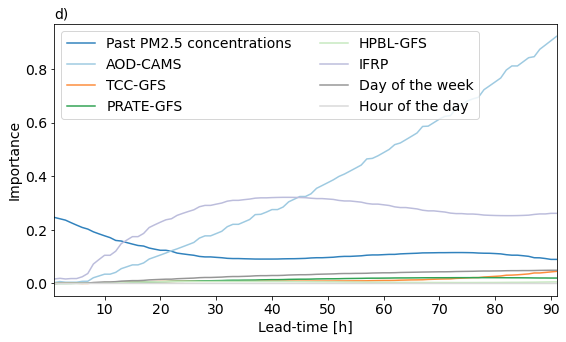

In [379]:
colors=mcp.gen_color(cmap="tab20c",n=8)

plt.figure(figsize=(9,5))
for ikey,key in enumerate(list(df_importances.keys())):
    plt.plot(np.arange(1,92,1),abs(df_importances[key]).rolling(3,min_periods=1).median(),label=key,color=colors[ikey])
plt.ylabel('Importance',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Lead-time [h]',fontsize=14)
plt.xlim(1,91)
# plt.ylim(0,350)
plt.title('d)',loc='left',fontsize=14)
plt.legend(fontsize=14,ncol=2)#,bbox_to_anchor=(1.,1.03))
plt.savefig('Figures/FeatureImportances_Permutations_v3',bbox_inches='tight')

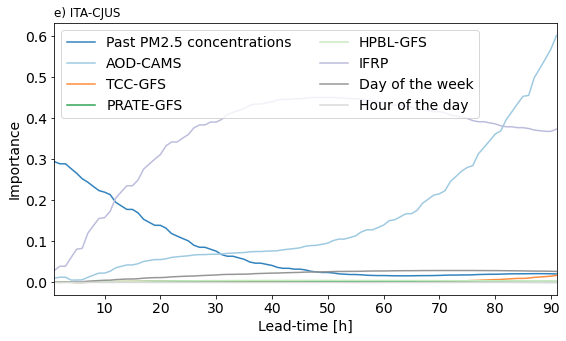

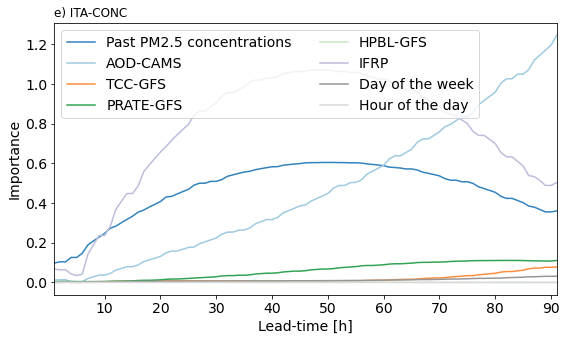

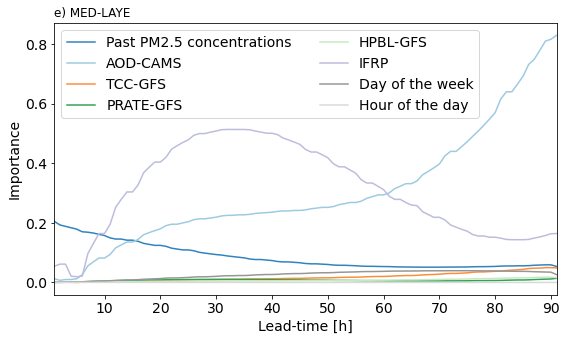

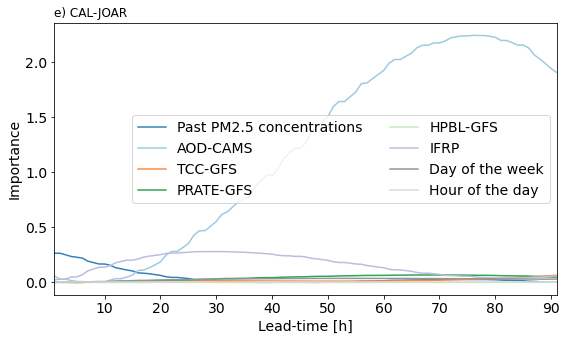

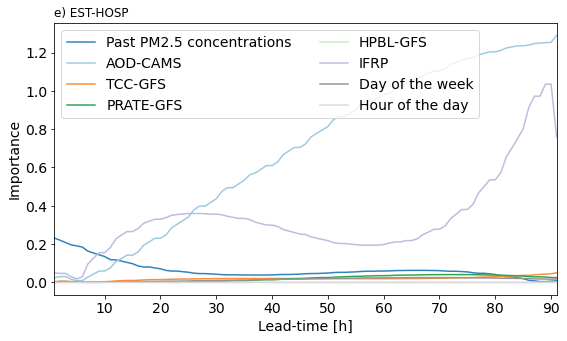

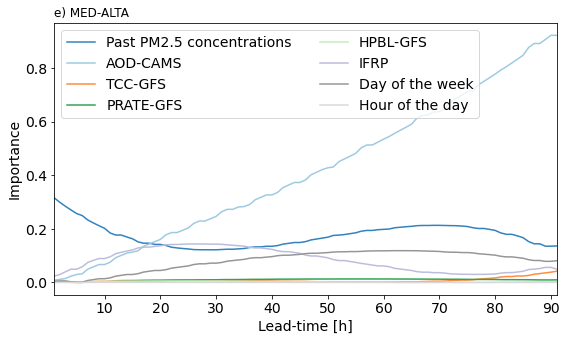

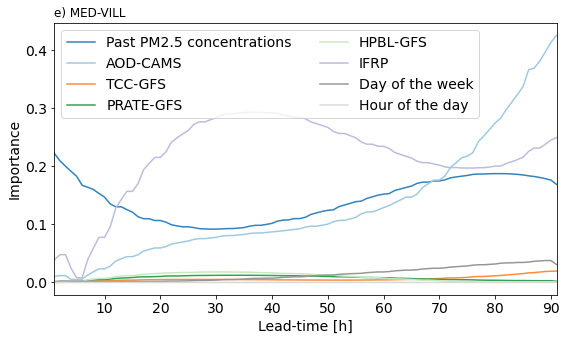

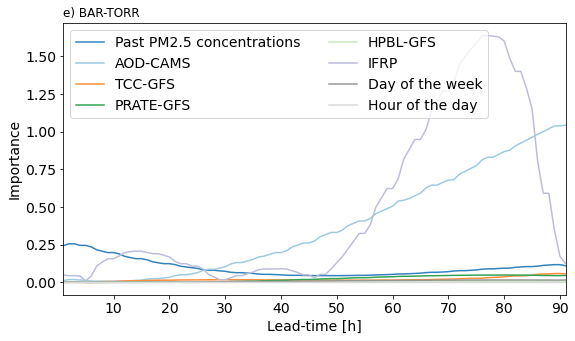

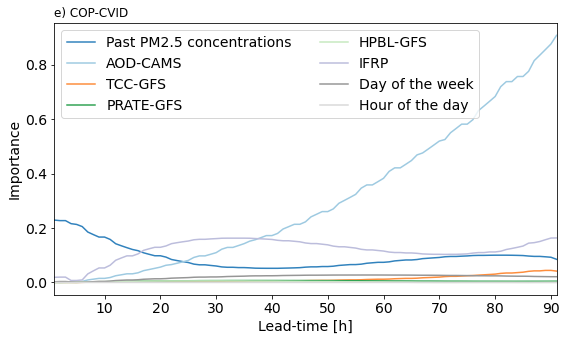

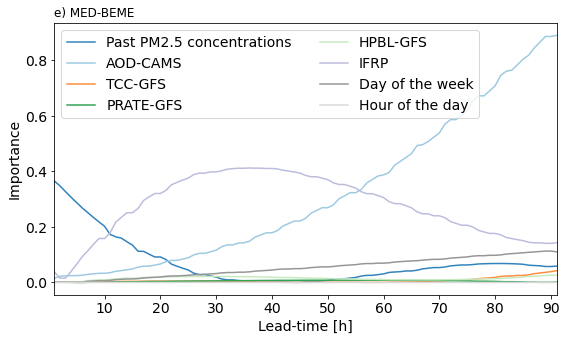

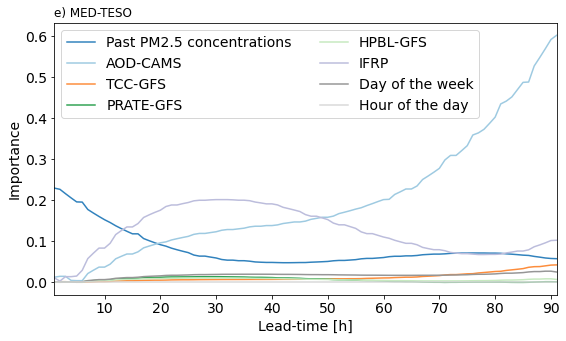

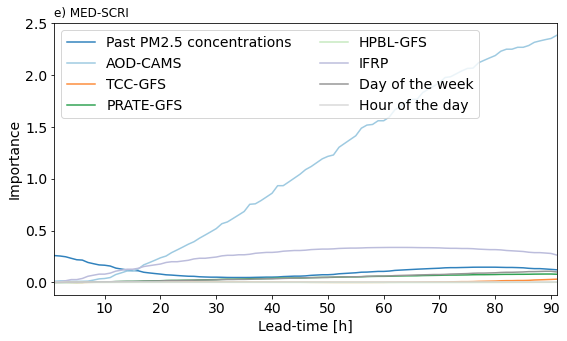

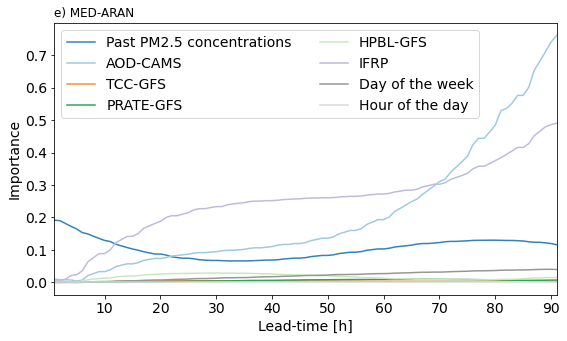

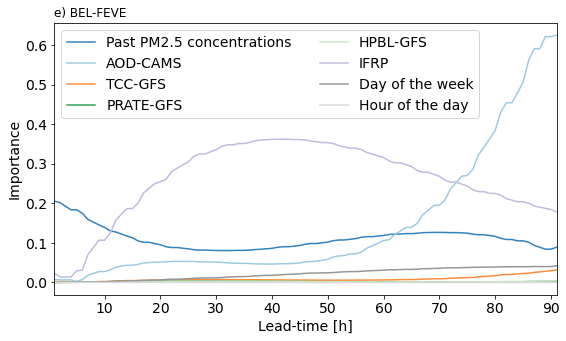

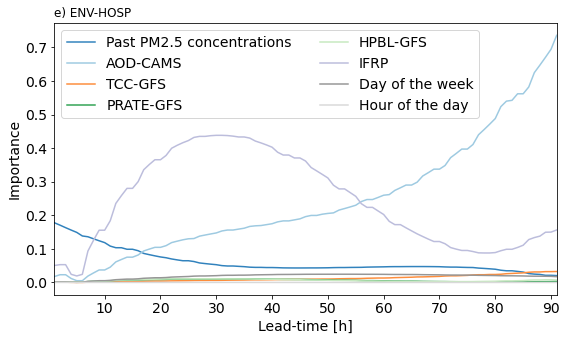

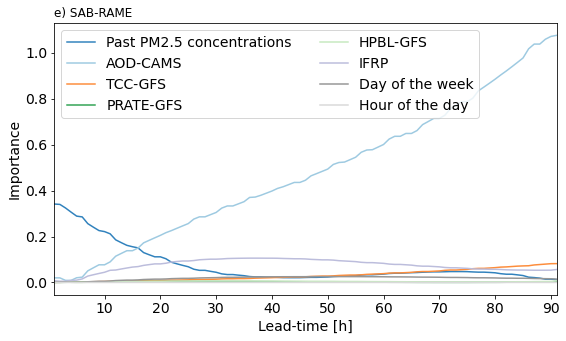

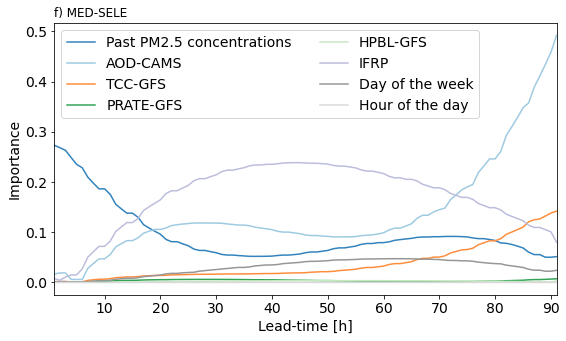

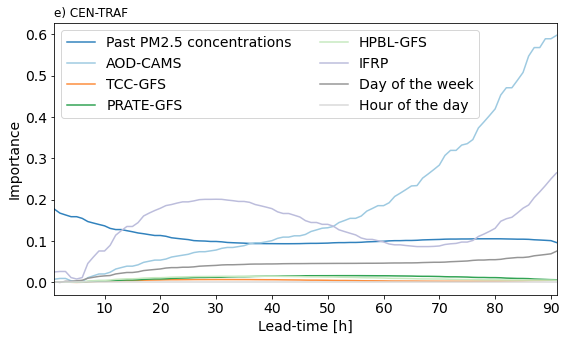

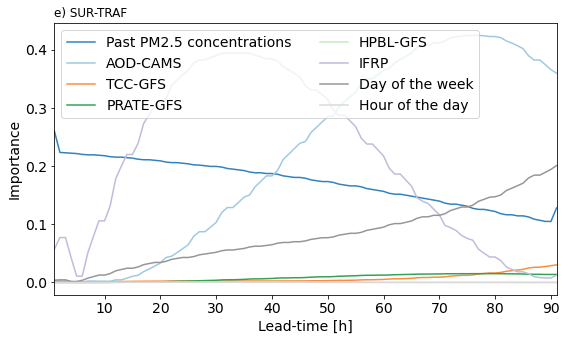

In [380]:
for s in range(len(importances_full)):
    mean_importance = importances_full[s]

    df_importances = pd.DataFrame()

    df_importances['Past PM2.5 concentrations'] = np.sum(mean_importance[0:48],axis=0)
    df_importances['AOD-CAMS'] = np.sum(mean_importance[48:81],axis=0)
    df_importances['TCC-GFS'] = np.sum(mean_importance[81:114],axis=0)
    df_importances['PRATE-GFS'] = np.sum(mean_importance[114:147],axis=0)
    df_importances['HPBL-GFS'] = np.sum(mean_importance[147:180],axis=0)
    df_importances['IFRP'] = np.sum(mean_importance[180:213],axis=0)
    df_importances['Day of the week'] = np.sum(mean_importance[213:221],axis=0)
    df_importances['Hour of the day'] = np.sum(mean_importance[221:269],axis=0)
    df_importances.index = [dt.datetime(2001,1,1) + dt.timedelta(hours = i) for i in range(1,96,5)]
    df_importances = df_importances.resample('H').interpolate(method='spline',order=3)
    
    colors=mcp.gen_color(cmap="tab20c",n=8)

    plt.figure(figsize=(9,5))
    for ikey,key in enumerate(list(df_importances.keys())):
        plt.plot(np.arange(1,92,1),abs(df_importances[key]).rolling(3,min_periods=1,center=True).median(),label=key,color=colors[ikey])
    plt.ylabel('Importance',fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Lead-time [h]',fontsize=14)
    plt.xlim(1,91)
#     plt.ylim(0,400)
    plt.legend(fontsize=14,ncol=2)#,bbox_to_anchor=(1.,1.03))
    plt.title('e) '+stations[s],loc='left')
    if stations[s]=='MED-SELE':
        plt.title('f) '+stations[s],loc='left')
    plt.savefig('Figures/PermutationFeatureImportances_v3_'+stations[s],bbox_inches='tight')

# permutation importance 30 permutations

In [386]:
from sklearn.inspection import permutation_importance

In [387]:
model_name

'GB_MO'

In [389]:
importances_full = []
for station in ['MED-ALTA']:
    estimator_temp = joblib.load('/var/data1/AQ_Forecast_DATA/trained_estimators_v3/'+station+'_'+model_name+'.mdl')
    importances = np.zeros([269,96])
    
    print(station)
    X = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_X.npy',allow_pickle=True)
    Y_validation = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_Y_validation.npy',allow_pickle=True)
    dates = np.load('/var/data1/AQ_Forecast_DATA/validation_results/'+station+'_dates.npy',allow_pickle=True)
    scaler_x = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_X.scl')
    scaler_y = joblib.load('/var/data1/AQ_Forecast_DATA/scalers/'+station+'_Y.scl')
    X_scaled = scaler_x.transform(X)
    Y_validation_scaled = scaler_y.transform(Y_validation)

    estimator_temp = joblib.load('/var/data1/AQ_Forecast_DATA/trained_estimators_v3/'+station+'_'+model_name+'.mdl')
    result = np.zeros([269,96])
    for lt in range(1,96,5):
        print(lt)
        result[:,lt] = permutation_importance(
            estimator_temp.estimators_[lt], X_scaled, Y_validation_scaled[:,lt], 
            n_repeats=30, random_state=42, n_jobs=1)['importances_mean']
    importances_full.append(result)

MED-ALTA
1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91


In [390]:
# np.save('/var/data1/AQ_Forecast_DATA/results/PermutationImportances_v3.npy',np.array(importances_full))

In [391]:
importances_full=np.array(importances_full)

In [392]:
importances_full = importances_full[:,:,np.arange(1,96,5)]

In [393]:
importances_full = abs(importances_full)

In [394]:
mean_importance = np.mean(importances_full,axis=0)

df_importances = pd.DataFrame()

df_importances['Past PM2.5 concentrations'] = np.sum(mean_importance[0:48],axis=0)
df_importances['AOD-CAMS'] = np.sum(mean_importance[48:81],axis=0)
df_importances['TCC-GFS'] = np.sum(mean_importance[81:114],axis=0)
df_importances['PRATE-GFS'] = np.sum(mean_importance[114:147],axis=0)
df_importances['HPBL-GFS'] = np.sum(mean_importance[147:180],axis=0)
df_importances['IFRP'] = np.sum(mean_importance[180:213],axis=0)
df_importances['Day of the week'] = np.sum(mean_importance[213:221],axis=0)
df_importances['Hour of the day'] = np.sum(mean_importance[221:269],axis=0)
df_importances.index = [dt.datetime(2001,1,1) + dt.timedelta(hours = i) for i in range(1,96,5)]
df_importances = df_importances.resample('H').interpolate(method='spline',order=3)

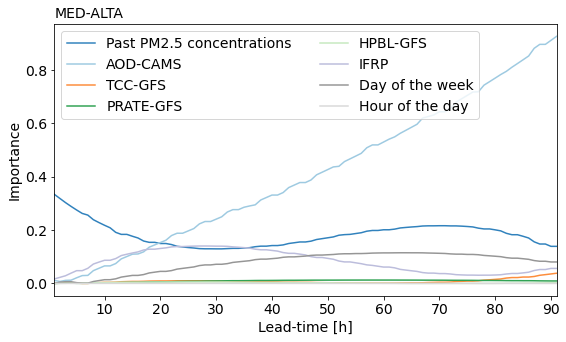

In [396]:
colors=mcp.gen_color(cmap="tab20c",n=8)

plt.figure(figsize=(9,5))
for ikey,key in enumerate(list(df_importances.keys())):
    plt.plot(np.arange(1,92,1),abs(df_importances[key]).rolling(3,min_periods=1).median(),label=key,color=colors[ikey])
plt.ylabel('Importance',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Lead-time [h]',fontsize=14)
plt.xlim(1,91)
# plt.ylim(0,350)
plt.title('MED-ALTA',loc='left',fontsize=14)
plt.legend(fontsize=14,ncol=2)#,bbox_to_anchor=(1.,1.03))
plt.savefig('Figures/FeatureImportances_Permutations_test_30',bbox_inches='tight')

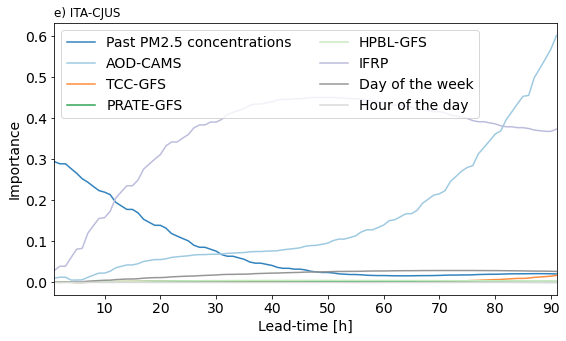

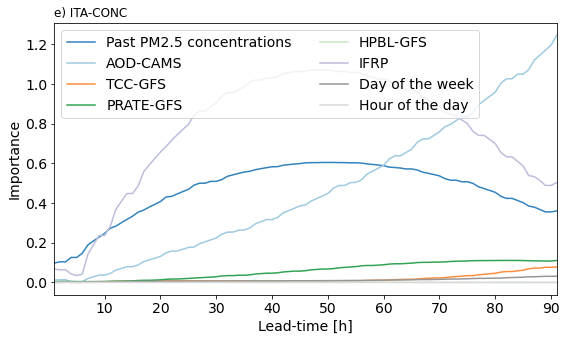

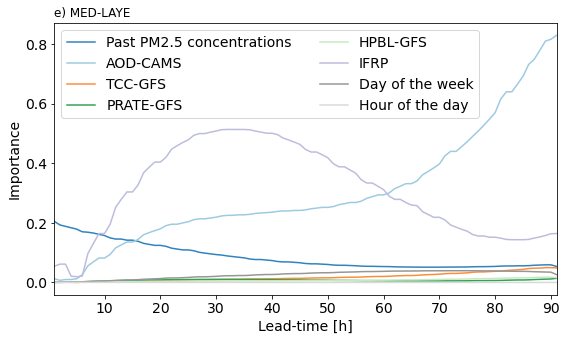

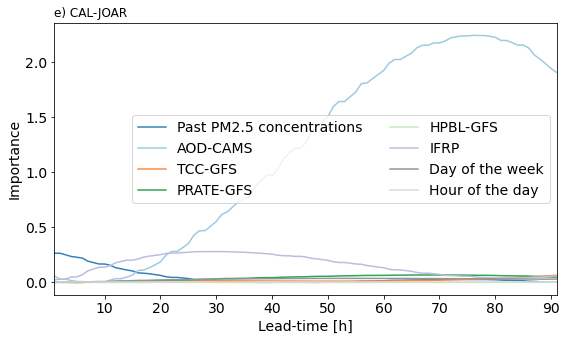

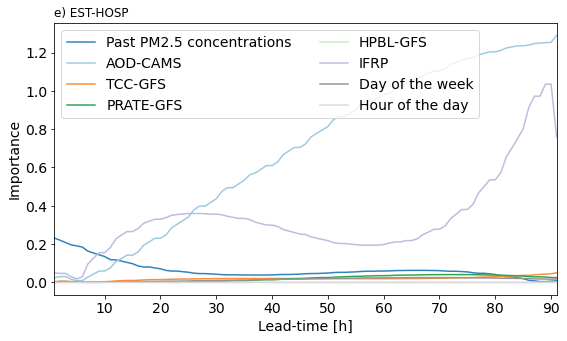

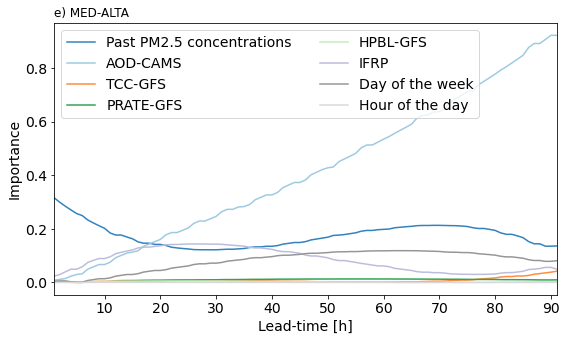

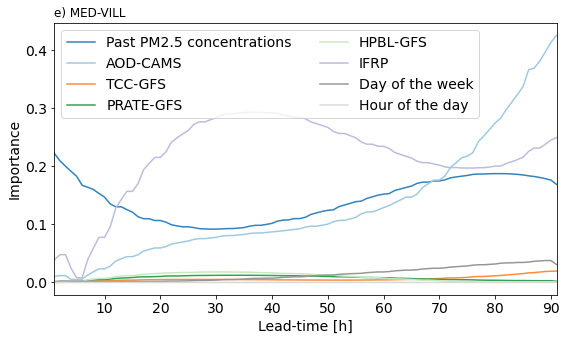

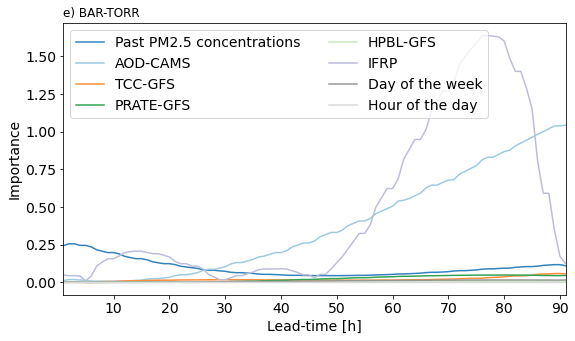

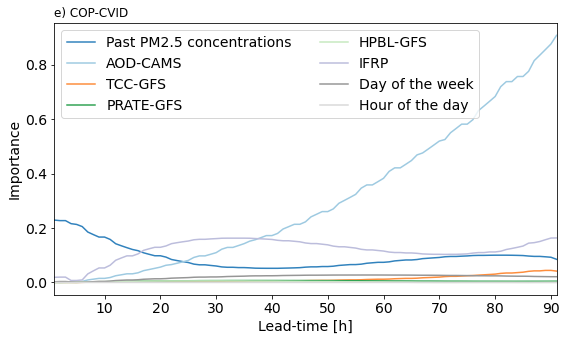

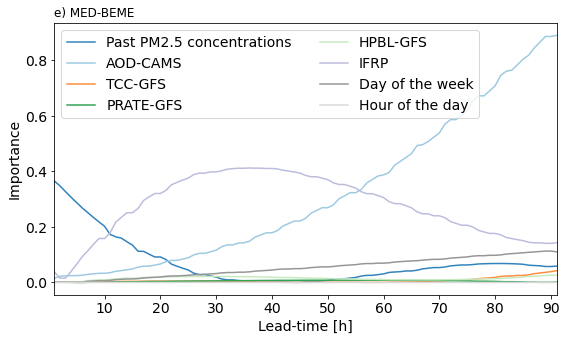

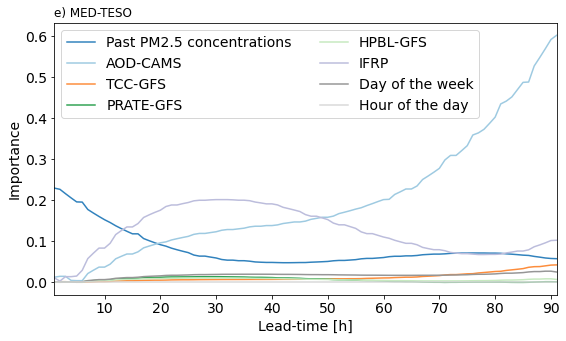

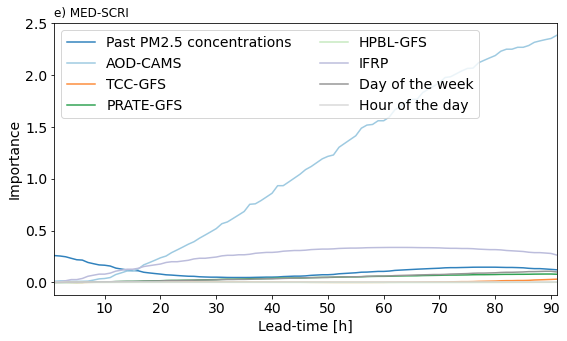

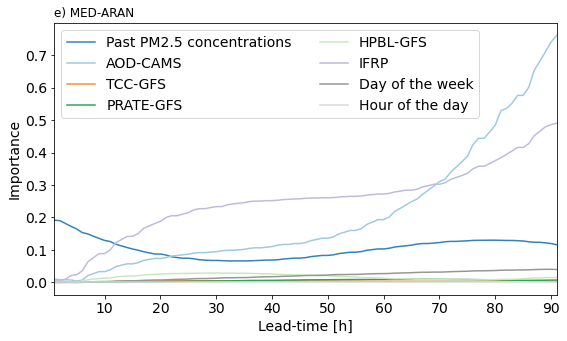

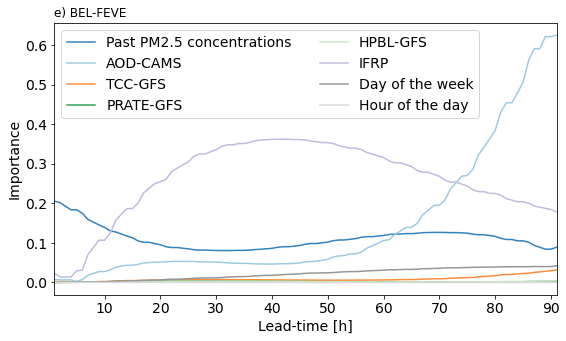

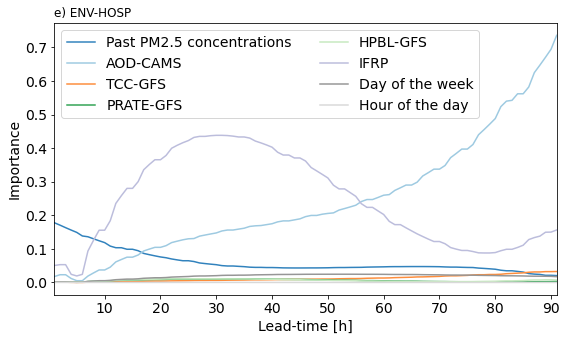

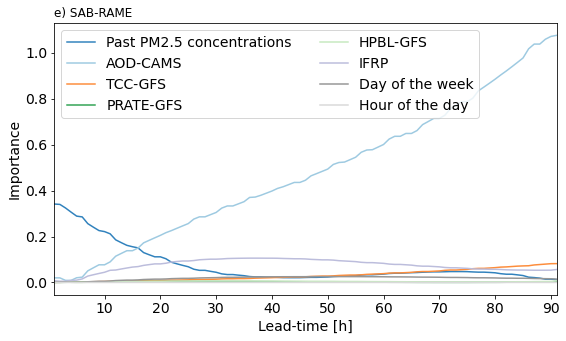

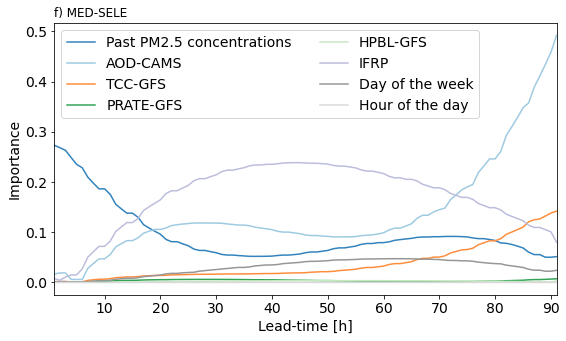

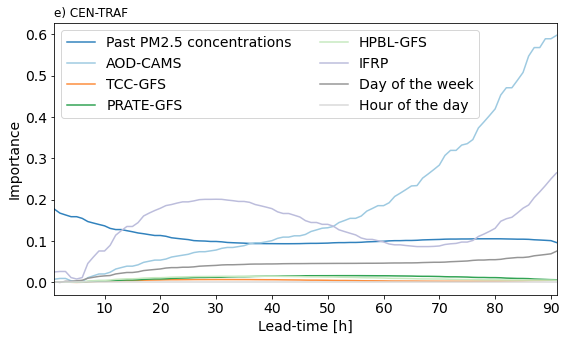

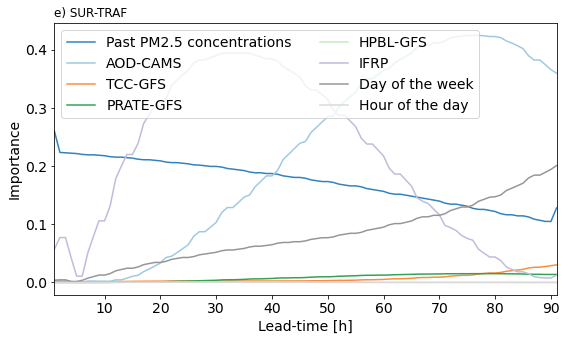

In [380]:
for s in range(len(importances_full)):
    mean_importance = importances_full[s]

    df_importances = pd.DataFrame()

    df_importances['Past PM2.5 concentrations'] = np.sum(mean_importance[0:48],axis=0)
    df_importances['AOD-CAMS'] = np.sum(mean_importance[48:81],axis=0)
    df_importances['TCC-GFS'] = np.sum(mean_importance[81:114],axis=0)
    df_importances['PRATE-GFS'] = np.sum(mean_importance[114:147],axis=0)
    df_importances['HPBL-GFS'] = np.sum(mean_importance[147:180],axis=0)
    df_importances['IFRP'] = np.sum(mean_importance[180:213],axis=0)
    df_importances['Day of the week'] = np.sum(mean_importance[213:221],axis=0)
    df_importances['Hour of the day'] = np.sum(mean_importance[221:269],axis=0)
    df_importances.index = [dt.datetime(2001,1,1) + dt.timedelta(hours = i) for i in range(1,96,5)]
    df_importances = df_importances.resample('H').interpolate(method='spline',order=3)
    
    colors=mcp.gen_color(cmap="tab20c",n=8)

    plt.figure(figsize=(9,5))
    for ikey,key in enumerate(list(df_importances.keys())):
        plt.plot(np.arange(1,92,1),abs(df_importances[key]).rolling(3,min_periods=1,center=True).median(),label=key,color=colors[ikey])
    plt.ylabel('Importance',fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Lead-time [h]',fontsize=14)
    plt.xlim(1,91)
#     plt.ylim(0,400)
    plt.legend(fontsize=14,ncol=2)#,bbox_to_anchor=(1.,1.03))
    plt.title('e) '+stations[s],loc='left')
    if stations[s]=='MED-SELE':
        plt.title('f) '+stations[s],loc='left')
    plt.savefig('Figures/PermutationFeatureImportances_v3_'+stations[s],bbox_inches='tight')